# Working with unconventional data
## Text Analysis  and a bit of maps using R
<b>Valeria Rueda <br>
University of Nottingham, School of Economics <br>

- This is an introductory class to text analysis using R. <br>
- Many of the tools used here are applicable to other languages (Stata, Python)
- Here are all the packages we need

In [551]:
#General data handling
library(tidyverse)
library(lubridate)
library(reshape2)
#Maps
library(ggmap)
library(sf)
sf::sf_use_s2(FALSE) ## s2 in sf version 1.0 slows down the code too much
#Text analysis
library(tidytext)
library(stopwords)
library(SnowballC)
library(wordcloud)
library(topicmodels)
# ML 
library(ranger) #Random Forests
library(glmnet) #LASSO
library(gamlr) #LASSO choice lambda AIC



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




## Structure
- A primer on data types
- Regular Expressions
- A taster of Maps in R
- Text as Data
    - Stemming and stop words
    - Bag of Words
    - TF-IDF

# Types of data

- <b>Character:</b> "a", "Valeria teaches things"
- <b>Numeric:</b> 1, 2, $\pi$, $e$
- <b>Integer:</b> 1,2,.. $n \in \mathbb{N}$
- <b>Logical:</b> TRUE, FALSE
- <b>Complex:</b> 1+3$i$ 


In [458]:
class(345)
class(1==3)
class("today is March 23rd")

[1] "numeric"

[1] "logical"

[1] "character"

# Regular Expressions
- Regular expressions (Regex): Metalanguage to characterize text
- A what? 
    - <b> Metalanguage: </b> A language used to make statements about another language
- A language (somewhat common) to describe the context of a string
- A string is a sequence of characters: TEXT!





# Regular Expressions
## Let's start with an example

<br> 
An example will be helpful to see why this is powerful

In [459]:

text <- c("This is my lecture for the MRes, if you have any question, please email me valeria.rueda@nottingham.ac.uk", 
          "you could also email Natalia to learn about all the other amazing masterclasses!: natalia.bas@nottingham.ac.uk")
print(text)

[1] "This is my lecture for the MRes, if you have any question, please email me valeria.rueda@nottingham.ac.uk"     
[2] "you could also email Natalia to learn about all the other amazing masterclasses!: natalia.bas@nottingham.ac.uk"


In [460]:
str_detect(text, "valeria.rueda@nottingham.ac.uk")

[1]  TRUE FALSE

In [461]:
str_detect(text, "[a-z]+.[a-z]+@[a-z]+.ac.uk")

[1] TRUE TRUE

In [462]:
where <- str_locate(text,"[a-z]+.[a-z]+@[a-z]+.ac.uk")
where

start,end
76,105
83,110


In [463]:
str_extract(text,"[a-z]+.[a-z]+@[a-z]+.ac.uk")

[1] "valeria.rueda@nottingham.ac.uk" "natalia.bas@nottingham.ac.uk"

# Regular Expressions
## How to? 

- We need to know: 
    - The syntax
    - The comands to locate, extract, etc.

# The syntax: Special characters
- There are "literal characters" 
    - For a Regex, "a" means "a"
- There are special characters
    - For a Regex, "." means "any character"
- But sometimes, I actually need to match a full stop "."
    - For that, you escape: "\\" tells the computer to take what's next _literally_
- Example Next


In [464]:
str_extract_all("This is life as we know it.","a")
str_extract_all("This is life as we know it.",".")
str_extract_all("This is life as we know it.","\\.") #In R you have to escape twice

[[1]]
[1] "a"

[[1]]
 [1] "T" "h" "i" "s" " " "i" "s" " " "l" "i" "f" "e" " " "a" "s" " " "w" "e" " "
[20] "k" "n" "o" "w" " " "i" "t" "."

[[1]]
[1] "."

## Some Examples of tokens and their meanings

|Character | Meaning| 
|-----|---------|
| `.` | Any Character |
| `^` | Start of String|
| `$` | End of String|
|`\` | Escape a character* | 
| `*`| Zero or more of the previous |
|`+` | One or more of te the previous |
|`?` | 0 or 1 of the previous |
|`{3}` | Exactly 3 of the previous |
|`{0,10}` | 0 to 10 of the previous |
|`\s` | Space |
|`\S` | Not Space |


$^*$ For technical reasons, most times you need to escape twice `\\` (read about escape in string literals if you want to know more)



With `stringr`, character classes are also neatly defined

|Character | Meaning| 
|-----|---------|
| `[:digit:]` | Any Digit 0 1 2... (equivalent: `[0-9]`) |
| `[:alpha:]` | Any alphabetic character (equivalent `[A-z]`)|
| `[:upper:]` | Any upper-case character (equivalent `[A-Z]`) |
| `[:lower:]` | Any lower-case character (equivalent `[a-z]`) |
|`[:blank:]` | Blank spaces (tab and space) | 
| `[:space:]`| Space chars: tab, newline, space, carriage return, vertical tab,... |

 - You don't need to memorize this. There are a million guiding pages online. Just google "r regex"
 - This Cheatsheet will help us today. It's in ["docs/R_strings/cheatsheet.pdf"](https://uniofnottm-my.sharepoint.com/:b:/g/personal/valeria_rueda_nottingham_ac_uk/EQSq0T7JHBBArMZw1g4JKoIBH9sfY4xx5LHhl0XotGUKoQ?e=0HPtEo). Or find it if you google "R Stringr Cheatsheet"

# Your turn: Activity 
- We will use a database of all pubs in England. The database was shared with you in the lecture package. It's called `open_pubs_2020-07_forclass.csv`

In [465]:
# Load the dataset
df <- read.csv("../data/open_pubs_2020-07_forclass.csv")
head(df, n = 3)
dim(df)

,X,id,name,address_raw,latitude,longitude
,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,1,24,Angel Inn,43 Friars Street SUDBURY Suffolk CO10 2AG,52.03631,0.727924
2,2,33,Ark Bar Restaurant,Ark Bar And Restaurant Cattawade Street Brantham MANNINGTREE CO11 1RH,51.95870,1.057832
3,3,60,Black Boy,Black Boy Hotel 7 Market Hill SUDBURY Suffolk CO10 2EA,52.03869,0.730226


[1] 51021     6

- **Task:** create a list called `postcode` that gives you the postcode of each pub
- Use the cheatsheet and all googling you want ("docs/R_strings/cheatsheet.pdf").

## Challenge
- Postcode format: \[OUTWARD AREA\] \[SPACE\] \[INWARD AREA\]
- But lenth varies:

|POSTCODE | | | | | 
|-----| ----| -----| ----| ---| 
|OUTWARD AREA| | INWARD AREA| |Format summary |
| AREA | DISTRICT| SECTOR | UNIT| | 
|SW| 1W| 0 | NY | AA9A 9AA| 
| W| 1A | 0 |AX | A9A 9AA|
|NG | 7 | 2| RD|  AA9 9AA | 
|PO | 16| 7 | GZ| AA99 9AA|
|L | 1 | 8| JQ| A9 9AA|
|B | 33|  8| TH| A99 9AA| 

 

In [466]:
# in R, this is an object, it does not need to be tied to a db: 
x <- 3
y <- c(2,5, 10) # a list
df$test <- seq(1:length(df$id))
print(x)
print(y)
head(df, n= 3)

[1] 3
[1]  2  5 10


,X,id,name,address_raw,latitude,longitude,test
,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,1,24,Angel Inn,43 Friars Street SUDBURY Suffolk CO10 2AG,52.03631,0.727924,1
2,2,33,Ark Bar Restaurant,Ark Bar And Restaurant Cattawade Street Brantham MANNINGTREE CO11 1RH,51.95870,1.057832,2
3,3,60,Black Boy,Black Boy Hotel 7 Market Hill SUDBURY Suffolk CO10 2EA,52.03869,0.730226,3


In [467]:
str_trim(" this has     trailing and inside  white spaces   ")
str_squish(" this has     trailing and inside  white spaces   ")
df$address_raw <- str_squish(df$address_raw)


[1] "this has     trailing and inside  white spaces"

[1] "this has trailing and inside white spaces"

In [468]:
 # Is there a postcode present --> focus on selecting end of string?
pcpresent <- str_detect(df$address_raw, "\\s[:alnum:]+\\s[:alnum:]+$")
sum(pcpresent)
dim(df)
postcode <- str_extract(df$address_raw, "\\s[:alnum:]+\\s[:alnum:]+$") 
df$postcode <- postcode  # Create the variable in the dataset with the postcode
set.seed(2022)
df[sample(length(postcode), 10), ]

[1] 51021

[1] 51021     7

,X,id,name,address_raw,latitude,longitude,test,postcode
,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>
42419,42556,436223,The Tabard,The Tabard Herringthorpe Valley Road Herringthorpe Rotherham South Yorkshire S65 3BA,53.42714,-1.324393,42419,S65 3BA
35639,35759,379226,Newdigate Colliery & District Sports & Social Club,Newdigate Sports And Social Club Smorrall Lane Bedworth CV12 0JP,52.47402,-1.499843,35639,CV12 0JP
41668,41804,429710,Silks Gentlemens Lounge,2 Sovereign Place Leeds LS1 4SP,53.79425,-1.546128,41668,LS1 4SP
2751,2757,28883,The Globe Public House,The Globe 26 Union Street Luton LU1 3AN,51.87544,-0.414585,2751,LU1 3AN
49628,49772,533371,Tonmawr RFC,Tonmawr Rugby Football Club Tonmawr Road Tonmawr Port Talbot Neath Port Talbot SA12 9UB,51.64573,-3.752324,49628,SA12 9UB
10473,10516,115546,The Atlas,16 Seagrave Road London SW6 1RX,51.48590,-0.195997,10473,SW6 1RX
34040,34160,365463,The Prince Of Wales,The Prince Of Wales 84-85 Cambridge Street Birmingham B1 2NP,52.47981,-1.913290,34040,B1 2NP
8029,8051,81577,Bunny Hill Riding Centre,Bunny Hill Riding School Bunny Hill Top Costock Nottinghamshire LE12 6XN,52.84659,-1.143037,8029,LE12 6XN
33719,33836,359710,Cock Inn,Cock Inn 33 Jiggins Lane Birmingham B32 3LE,52.43681,-1.995424,33719,B32 3LE


## Activity  2
- **GOAL:** Let's make a map of all the pubs with a name that evokes royalty
- **INTERMEDIATE STEP:** let's create a new dataset with only those "royalist" pubs
- Go Ahead! 

In [469]:
df$name[sample(length(df$name), 10)]

[1] "The Hoppers Hut"      "Vardre RFC"           "The Merchant"        
 [4] "The Red Lion"         "Beehive Inn"          "The Pheasant Inn"    
 [7] "The Old Black Lion"   "BBC Bristol Club Ltd" "Holyhead"            
[10] "Jackie's Bar"

**Steps: (1) preprocess names variable; (2) flag all royal names; (3) make a new dataset with royal pubs only**

In [470]:
df$name_low <- tolower(df$name)
royal <- c("royal", "queen", "king", "prince", "lord", "baron", "crown", "palace" )

In [471]:
test <- str_detect( df$name_low, "royal")
sum(test)
test[sample(length(test), 10)]

[1] 1039

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

Now generalize that...

## Operations on logical vectors may be useful...

In [472]:
c(FALSE, FALSE, TRUE, FALSE) | c(TRUE, FALSE, TRUE, FALSE)

[1]  TRUE FALSE  TRUE FALSE

In [473]:
init <- rep(FALSE, length(df$name_low)) ## initialize a "FALSE" vector
for (R in royal) {
    print(R)
    init <- init | str_detect(df$name_low, R)
    print(sum(init))
}
df$royal <- init
rm(init)

[1] "royal"
[1] 1039
[1] "queen"
[1] 1454
[1] "king"
[1] 2677
[1] "prince"
[1] 2950
[1] "lord"
[1] 3114
[1] "baron"
[1] 3121
[1] "crown"
[1] 3959
[1] "palace"
[1] 3997


**Note:** Loops are not the most efficient in R. Read about `apply` functions if you want to increase performance of your codes

#### Now let's make the database of royal pubs


In [474]:
df.roy <- subset(df, royal) ## This is from dplyr, from tidyverse packgs.
#It tells to subset if df$royal == TRUE
head(df.roy, n = 3)

,X,id,name,address_raw,latitude,longitude,test,postcode,name_low,royal
,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
12,12,198,Crown Inn,Cattawade Street Brantham MANNINGTREE Essex CO11 1RE,51.95668,1.057899,12,CO11 1RE,crown inn,TRUE
24,24,395,Kings Head,132 High Street Bildeston IPSWICH Suffolk IP7 7ED,52.10824,0.907990,24,IP7 7ED,kings head,TRUE
25,25,396,Kings Head Inn,115 Bures Road Great Cornard SUDBURY Suffolk CO10 0JE,52.02702,0.744328,25,CO10 0JE,kings head inn,TRUE


In [475]:
## Same as: 
other <- df[df$royal, ]
head(other, n = 3)
rm(other)

,X,id,name,address_raw,latitude,longitude,test,postcode,name_low,royal
,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
12,12,198,Crown Inn,Cattawade Street Brantham MANNINGTREE Essex CO11 1RE,51.95668,1.057899,12,CO11 1RE,crown inn,TRUE
24,24,395,Kings Head,132 High Street Bildeston IPSWICH Suffolk IP7 7ED,52.10824,0.907990,24,IP7 7ED,kings head,TRUE
25,25,396,Kings Head Inn,115 Bures Road Great Cornard SUDBURY Suffolk CO10 0JE,52.02702,0.744328,25,CO10 0JE,kings head inn,TRUE


## Intermediate wrap-up
- We have created `df.roy`, which has the names and addresses of all pubs in England with royal names
- Now our goal is to make a map of them, how can we do so?

- In R, you can use the command `geocode` from the `ggmap` library to geocode things. 
- It allows you to use the Google API. You can just search for things as you would search on Google Maps. Here, you could search the postcodes you've just extracted! 
- Get a Google API key if you want to do this. 

- **Today** I will give you the coordinates, they are in the DB...

## Let's make a map


In [476]:
mapuk <- st_read("../data/uk_map/uk_bounds.shp")

Reading layer `uk_bounds' from data source 
  `/Users/valeriarueda/Dropbox/Mac/Documents/GitHub/teach_textanalysis22/data/uk_map/uk_bounds.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 3 features and 10 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -8.649996 ymin: 49.86478 xmax: 1.763571 ymax: 60.86078
Geodetic CRS:  WGS 84


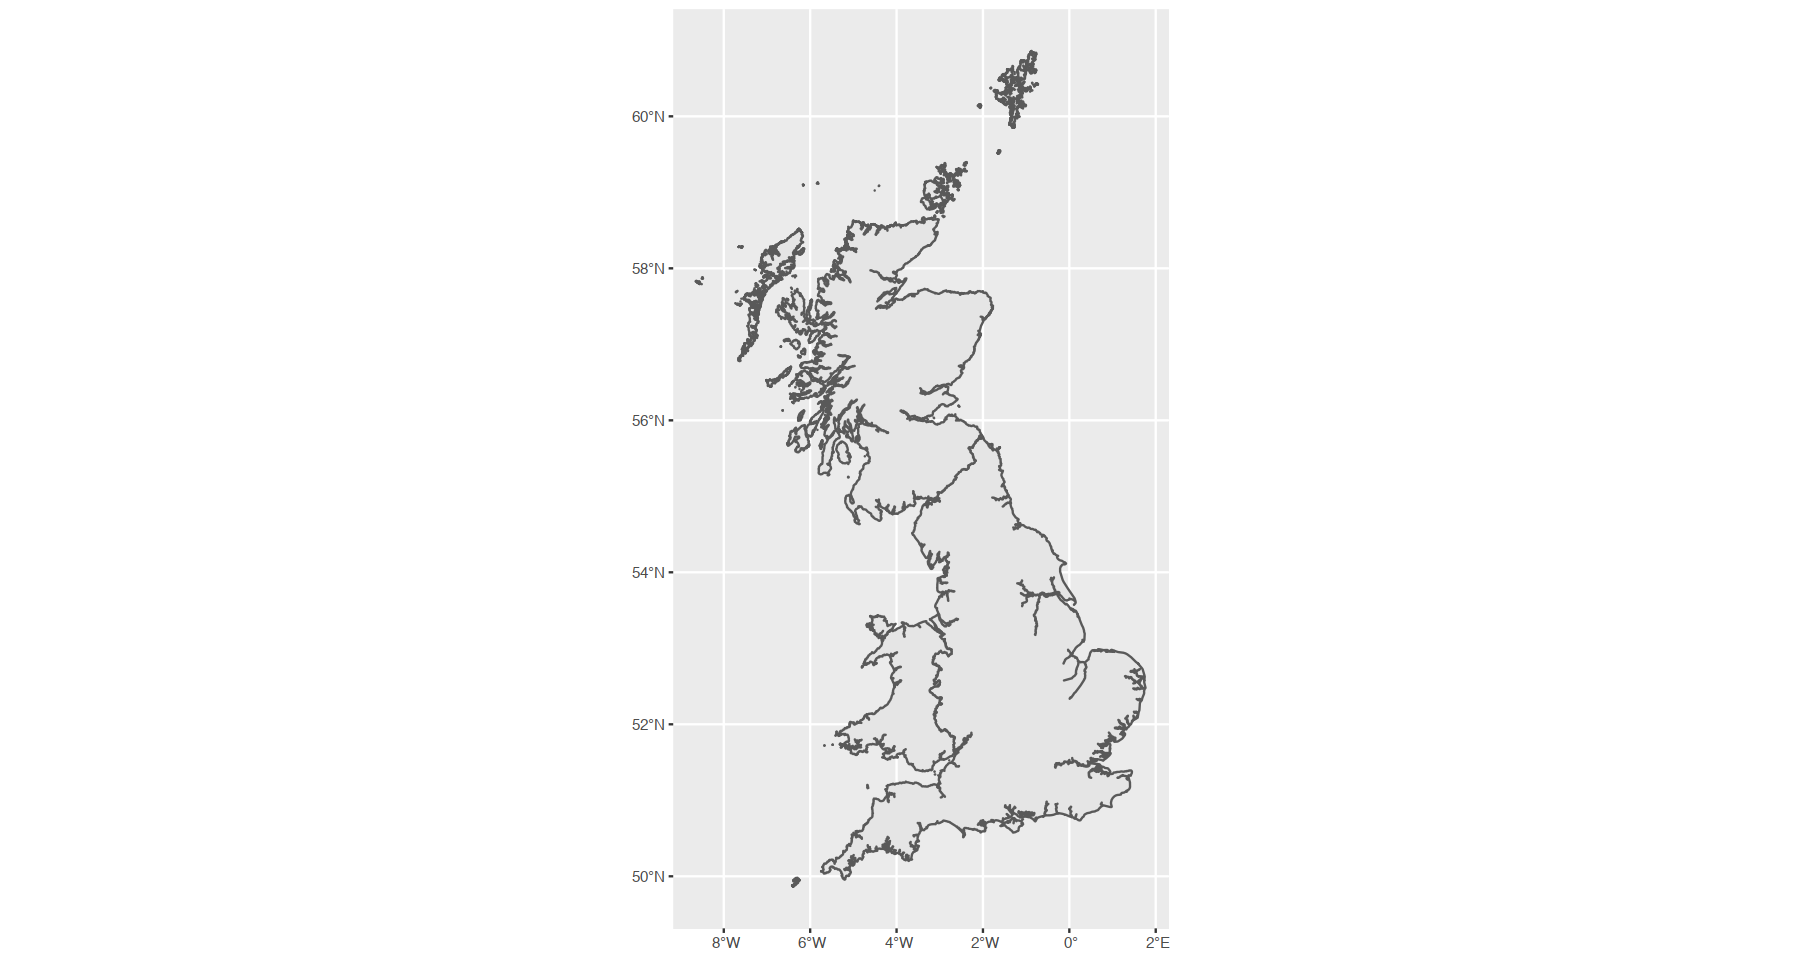

In [477]:
p <- ggplot() + geom_sf(data = mapuk)
p

Let's add pubs

In [478]:
crs84 <- "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"
df.roy <- df.roy[!is.na(df.roy$latitude) & !is.na(df.roy$longitude),]
dim(df.roy)
pubs <- st_as_sf(df.roy, coords = c("longitude", "latitude"), crs = crs84)


[1] 3997   10

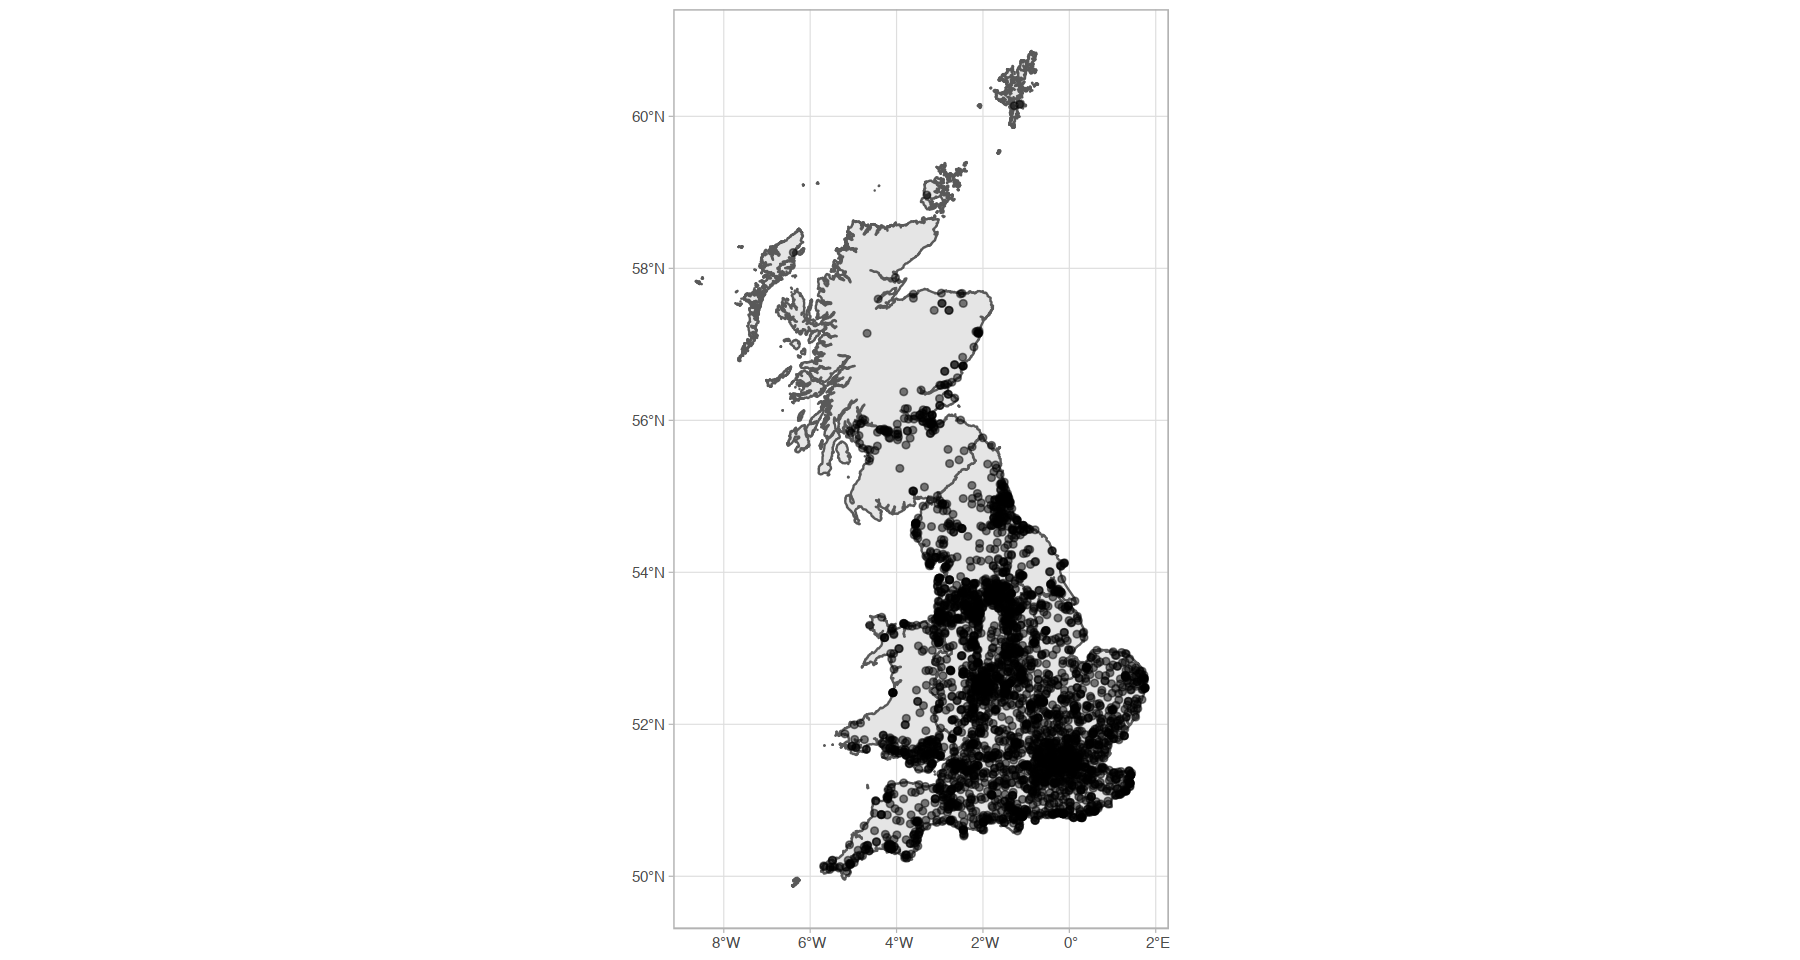

In [479]:
p + geom_sf(data = pubs, alpha = 0.5) +theme_light()

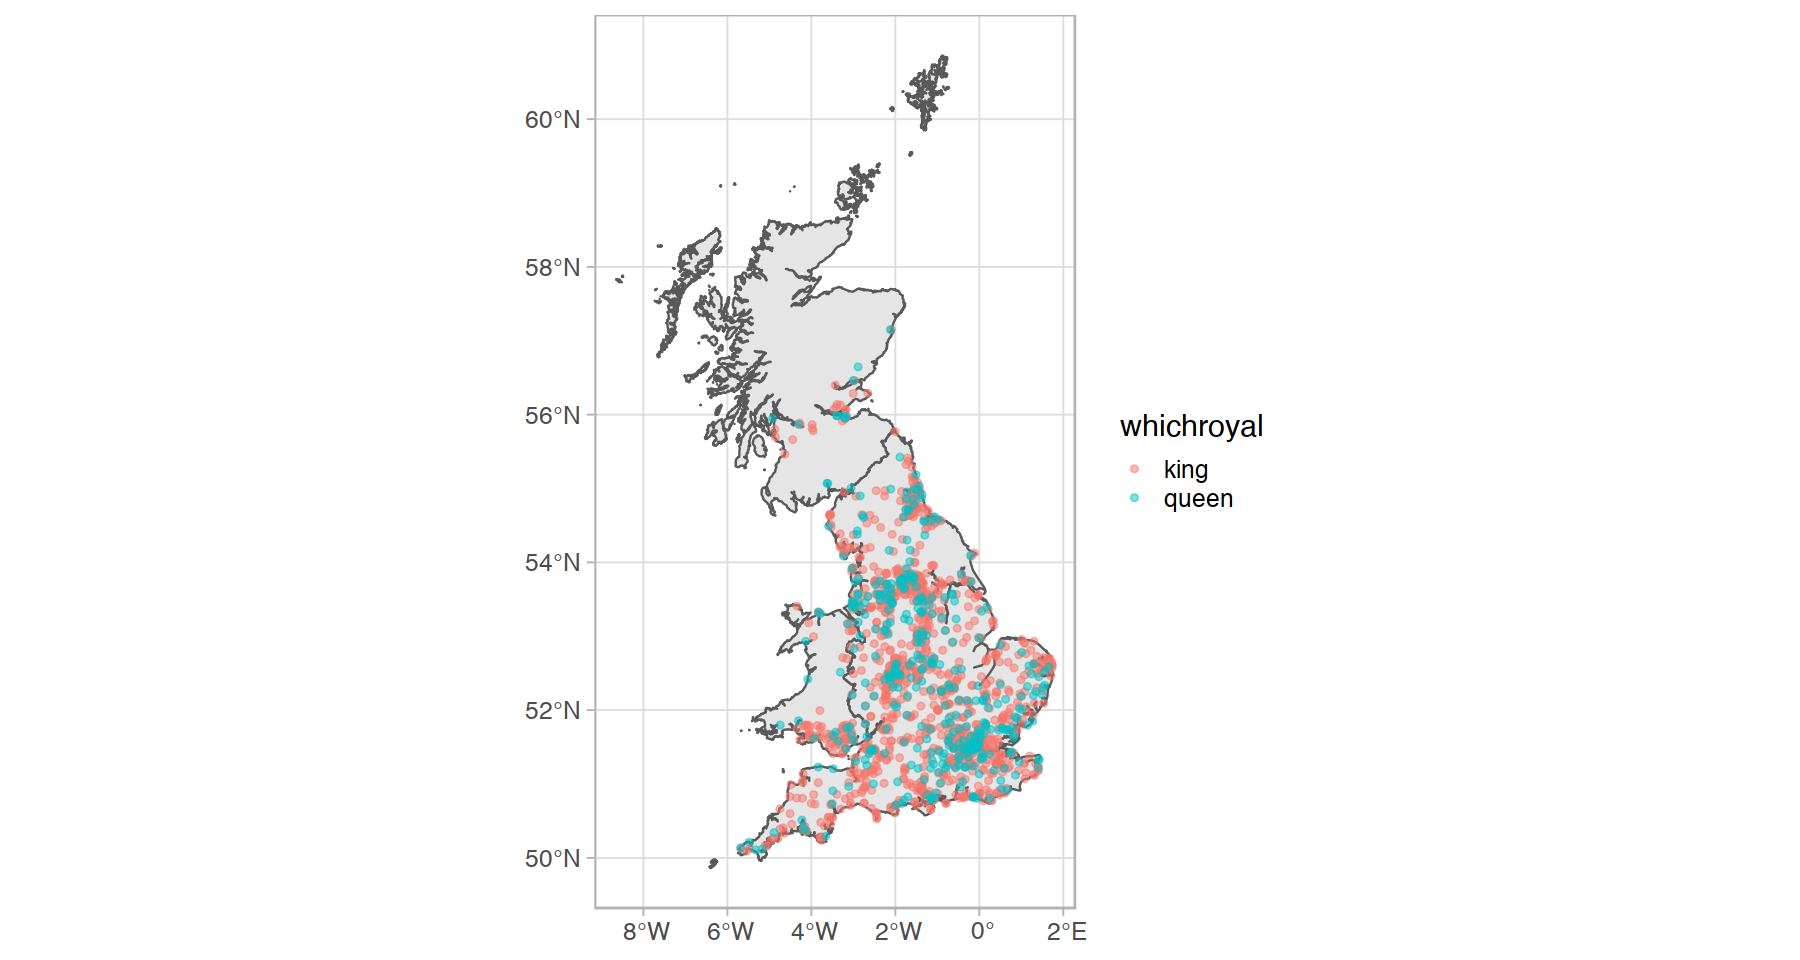

In [480]:
pubs$whichroyal <- str_extract(pubs$name_low, "queen|king")
p + geom_sf(data = pubs[!is.na(pubs$whichroyal),], alpha = 0.5, aes(col = whichroyal)) +theme_light(base_size = 18)

# Time for a break

In [481]:
rm(list = ls())  #Also time to clear the objects we have created

# Text as Data

- We are going to work with the ECB speeches. The data are in file `all_ECB_speeches20112022.csv`
- **Disclaimer:** I have not done any macro in a decade. 
- I downloaded the data from the [ECB Website "Speeches" dataset](https://www.ecb.europa.eu/press/key/html/downloads.en.html). I kept speeches since Draghi era  (2011-11-01) to today
- We are going to do this in R, to avoid introducing too many new tools
- But if you wish to go further with tet anaylsis you may need to do it in python 

In [482]:
df.sp <- read.csv("../data/all_ECB_speeches20112022.csv", sep = "|")  #Important to specify how cols are separated and how quotes are handled
dim(df.sp)

[1] 1107    7

In [483]:
names(df.sp)

[1] "date"     "speakers" "title"    "subtitle" "contents" "id"       "date2"

In [484]:
unique(df.sp$speakers) #Who speaks?

[1] "Fabio Panetta"               "Isabel Schnabel"            
 [3] "Frank Elderson"              "Philip R. Lane"             
 [5] "Christine Lagarde"           "Luis de Guindos"            
 [7] "Yves Mersch"                 "Benoît Cœuré"               
 [9] "Sabine Lautenschläger"       "Mario Draghi"               
[11] "Peter Praet"                 "Vítor Constâncio"           
[13] "Sabine Lautensc"             "Jörg Asmussen"              
[15] "José Manuel González-Páramo" "Lorenzo Bini Smaghi"        
[17] "Jürgen Stark"

In [485]:
df.sp %>% group_by(speakers) %>% tally() #How many speeches per speaker?

speakers,n
<chr>,<int>
Benoît Cœuré,184
Christine Lagarde,53
Fabio Panetta,32
Frank Elderson,13
Isabel Schnabel,37
Jörg Asmussen,37
José Manuel González-Páramo,7
Jürgen Stark,4
Lorenzo Bini Smaghi,1


## Labelled vs unlabelled data

- I recommend Athey's [ML and Economics Class](https://www.youtube.com/watch?v=Z0ZcsxI-HTs), avaialble on Youtube
- For any ML problem, we need to ask: is the data labelled or not? 
- The answer depends on the task you want to solve. 


|Question| Do I have Labels?|
|:-----|: ----| 
|1. What terms are most predictive of Christine Lagarde?| Yes: I know who is giving each speech|
|2. Has the number of speeches relating to climate increased? | No: I don't know whether a given speech talks about climate|


## Supervised vs unsupervised models

|Supervised|Unsupervised|
|:-----| :------|
|Labelled Dataset | Unlabelled Dataset|
|Stable environment, independent obs |  |
|What label $y$ is appropriate given $x$?| Which observations in my data are alike?|
|Regression: $\mathbb{E}[Y|X=x]$ |  Clustering: which observations "bunch" together? |
|Classification: $P(Y=y|X=x)$ (e.g. Logit) | Associations: "people who did $x_1$ also did $x_2$"|
|    |Dimensionality Reduction |


- **Today's goal:** Let's try to predict speeches given by Christine Lagarde.

## Pre-processing text
- No matter what the goal is, we need to transform all these _speeches_ into _data_
- In any case, we need: 
    - Clean text: lowercase, strip punctuation, etc. 
    - Reduce dimensionality:
        - Take out stop words: "the", "a", "and",...
        - Also common: Stemming. 
            - ["patient", "patiently", "patients",...] $\mapsto$ "patient"
        - More sophisticated (also slower): Lemmatization, accounts for context
            - feet $\mapsto$ foot

## Activity: First clean
- Do a first clean of the data: 
    - Everything lowercase
    - Remove punctuation
    - clean odd white spaces
    - Remove numbers? 

## Activity: First clean

In [486]:
FirstKlean <- function(STR) { #function to clean
    out <- tolower(STR)
    out <- str_squish(out)
    out <- str_replace_all(out, "[:punct:]", "")
    out <- str_replace_all(out, "[:digit:]", "")   
    return(out)
}


In [487]:
df.sp$contents.clean <- FirstKlean(df.sp$contents) 


In [488]:
substr(FirstKlean(df.sp$contents.clean[sample(dim(df.sp)[1],1)]), 1, 400)#Let's look at the output

[1] "statement by draghi president of the ecb at the thirtieth meeting of the imfc draghi president of the ecb washington dc october against the backdrop of an uneven global recovery which is also influencing the shape and strength of the euro area upturn the ecb has been determinedly pursuing its mandate of maintaining price stability over the medium term for the euro area following four quarters of m"

## Remove stopwords

In [489]:
stops <- stopwords(source = "smart") #One list of stopwords
stops[sample(length(stops), 20)]
stops <- c(stops, "speech", "speeches", "speak",  "speaks",
           "speakers", "lagarde", "draghi", "president", 
           "slide", "slides","banknote", "banknotes", "quarter", "der", "t" ) 

[1] "if"            "oh"            "presumably"    "used"         
 [5] "would"         "particularly"  "which"         "thru"         
 [9] "those"         "exactly"       "secondly"      "hereafter"    
[13] "definitely"    "according"     "more"          "corresponding"
[17] "tell"          "hither"        "why"           "regards"

**Activity** Remove stopwords

In [490]:
#Disclaimer: this is slow. If your computer is a bit slow, take a smaller database.
for (W in stops){ 
   regex <- paste0("[:blank:]", W, "[:blank:]") #why did I add blank spaces?
   df.sp$contents.clean <- str_replace_all(df.sp$contents.clean,regex, " ")
}


In [491]:
write.csv(subset(df.sp, select = -contents), "~/Desktop/test.csv")

In [492]:
p <- FirstKlean(df.sp$contents.clean[sample(dim(df.sp)[1],1)]) #Let's look at the output
print(substr(p, 1, 600)) ## First 600 characters of the cleaned text

[1] "making comprehensive assessment success member executive board ecb expansión financial eventmadrid ms pereda mr zambeletti mr albarracin governor linde ladies gentlemen preparing todays confronted laundry list topics talk ranging details comprehensive assessment happen outcome exercise supervisory approach intricacies banking regulation love time address issues today limit make comprehensive assessment success pertinent questions measures deal capital shortfalls general background goals exercise single supervisory mechanism ssm supervision significant euro area banks november advance conductin"


## Tokenizing
- Separating the units we care about (words)
- Here, R's library `tidytext` will be handy

In [493]:
df.words <- df.sp %>% unnest_tokens(word,contents.clean) %>% subset(select = c(id,word))

In [494]:
df.words[sample(dim(df.words)[1], 5),]

,id,word
,<chr>,<chr>
698697,id_0576,assets
136995,id_0121,financing
1251619,id_1009,inefficient
364524,id_0310,transmission
996290,id_0813,conditions


## Stemming and word counts
- For stemmming, the library `SnowballC` will be useful (recall it's already loaded). 


In [495]:
#Stemming 
df.words <- df.words %>% mutate(stem = wordStem(word))
df.words.n <- df.words %>% group_by(id, stem) %>% tally()

In [496]:
df.words.n[sample(dim(df.words.n)[1], 5),]

id,stem,n
<chr>,<chr>,<int>
id_0605,satisfactori,1
id_1025,sold,1
id_0138,view,1
id_0598,quantiti,1
id_0128,notabl,1


## TF-IDF representation

- We want to quantify how important terms are in each text. 
- Common way to do this: **term frequency-inverse document freqency**
- Consider a corpus with $M$ documents $d$ with $n_d$ words each that belonging to a dictionary of terms $t$

## TF-IDF representation

### Term Frequency:
- The number of times document $d$ contains term $t$ 
$$ tf(t,d) = \sum_{i=1}^{n_d} \mathbb{1}\{ \text{word}_i = t \} $$
- Commonly, this is normalized (L0, L1, or L2) to account for the length of $d$. In `bind_tf_idf` default is L0
$$ tf(t,d) = \frac{1}{n_d}\sum_{i=1}^{n_d} \mathbb{1}\{ \text{word}_i = t \} $$
- It does not look like you can change the normalisation (see [documentation](https://github.com/juliasilge/tidytext/blob/main/R/bind_tf_idf.R)). You can change it in Python's sklearn


## TF-IDF representation

### Inverse document frequency
$$idf(t) = \log\left[ \frac{1}{df(t)}\right]$$
- with $df(t)$ the "document frequency" of $t$. 
    - That is the number of documents that contain the term $t$
$$df(t) = \frac{\sum_{d=1}^{M} \mathbb{1}\{t \in d \}}{M}$$

## TF-IDF representation

### Inverse document frequency
$$tfidf(t,d) = tf \times idf$$
- The $tfidf(t,d)$ measures the importance of term $t$ in document $d$, relative to its importance in the entire corpus

## Doing the TF-IDF
- We are going to rely on the command `bind_tf_idf(tbl, term, document, n)`
- It needs, a table `tbl` containing: a column with terms or stems `term`; a document identifer `document`;  and a column of count of terms per document `n`

In [497]:
sp_tf_idf <- df.words.n %>%
  bind_tf_idf(stem, id, n)

- Common to trim too frequent and too infrequent stems
- What you define as too frequent or infrequent depends on your project (do you need to retain outliers)?
- Here, let's get rid of the top and bottom $5\%$
$$df(t,d) \geq 0.99 \Leftrightarrow idf(t,f) \leq \underbrace{\log(1/0.95)}_{0.05} $$
$$df(t,d) \leq 0.01 \Leftrightarrow idf(t,f) \geq \underbrace{\log(1/0.05)}_{2.99} $$


In [498]:
sp_tf_idf <- subset(sp_tf_idf, idf >= 0.05 & idf <= 2.99 )
head(sp_tf_idf, n = 2)


id,stem,n,tf,idf,tf_idf
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
id_0001,abrupt,1,0.0003750938,2.804716,0.001052032
id_0001,acceler,3,0.0011252813,1.512241,0.001701696


In [499]:
out <- left_join(sp_tf_idf, df.sp[,c("id", "date", "speakers", "title")], by = "id")
write.csv(out, "../data/output/speech_tfidf_20112022.csv")


## Wrap-up

- We have created a database that gives the tf-idf for each stem in the corpus
- We have identifiers linking each document to labels: name of the person giving the speech, or date
- Let's try to do something with it. 
- Use the database `speech_tf_idf_20112022.csv` that we just created

In [502]:
rm(list = setdiff(ls(), "df.words.n")) #Let's also clean things in memory a little bit
## I am goint to use df.words.n down the road so I'll keep it.


## Activity

- Using the database `speech_tf_idf_20112022.csv` build a model that predicts speeches given by Christine Lagarde

In [503]:
df <- read.csv("../data/output/speech_tfidf_20112022.csv") 
names(df)
unique(df$speakers)

[1] "X"        "id"       "stem"     "n"        "tf"       "idf"     
 [7] "tf_idf"   "date"     "speakers" "title"

[1] "Fabio Panetta"               "Isabel Schnabel"            
 [3] "Frank Elderson"              "Philip R. Lane"             
 [5] "Christine Lagarde"           "Luis de Guindos"            
 [7] "Yves Mersch"                 "Benoît Cœuré"               
 [9] "Sabine Lautenschläger"       "Mario Draghi"               
[11] "Peter Praet"                 "Vítor Constâncio"           
[13] "Sabine Lautensc"             "Jörg Asmussen"              
[15] "José Manuel González-Páramo" "Lorenzo Bini Smaghi"        
[17] "Jürgen Stark"

In [504]:
df$cl <- (df$speakers == "Christine Lagarde")
table(df$cl)
dim(df)
head(df, n =5)
df$stem[sample(length(df$stem), 5)]


 FALSE   TRUE 
471962  20592 

[1] 492554     11

,X,id,stem,n,tf,idf,tf_idf,date,speakers,title,cl
,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<lgl>
1,1,id_0001,abrupt,1,0.0003750938,2.8047163,0.0010520316,2022-02-28,Fabio Panetta,Small steps in a dark room: guiding policy on the path out of the pandemic,FALSE
2,2,id_0001,acceler,3,0.0011252813,1.5122407,0.0017016962,2022-02-28,Fabio Panetta,Small steps in a dark room: guiding policy on the path out of the pandemic,FALSE
3,3,id_0001,accommod,1,0.0003750938,0.9956938,0.0003734785,2022-02-28,Fabio Panetta,Small steps in a dark room: guiding policy on the path out of the pandemic,FALSE
4,4,id_0001,accompani,4,0.0015003751,1.4603328,0.0021910470,2022-02-28,Fabio Panetta,Small steps in a dark room: guiding policy on the path out of the pandemic,FALSE
5,5,id_0001,accumul,2,0.0007501875,1.9468139,0.0014604755,2022-02-28,Fabio Panetta,Small steps in a dark room: guiding policy on the path out of the pandemic,FALSE


[1] "vehicl"  "social"  "economi" "hinder"  "rise"

Do the most salient words differ between Christine Lagarde and the rest of the speakers? 

In [505]:
## Let's compare the most important terms for CL vs others

dfviz <- df %>% group_by(stem, cl) %>% summarize_at(vars(tf_idf), mean, na.rm = FALSE)
dfviz2 <- dfviz %>% group_by(cl) %>% slice_max(tf_idf, n = 50) 
dfviz2 <-  subset(dfviz2, stem != 'cœuré') #Technicality with special characters

In [506]:
p1 <- ggplot(data = subset(dfviz2, !cl) , aes( x= tf_idf, y = reorder(stem, tf_idf))) + 
geom_bar(stat = "identity", fill = "#FF6B35")  + theme_light(base_size = 16) #Plot for all others
p2 <- ggplot(data = subset(dfviz2, cl), aes( x= tf_idf, y = reorder(stem, tf_idf))) + 
geom_bar(stat = "identity", fill = "#1A659E") + theme_light(base_size = 16) # Plot for Christine Lagarde

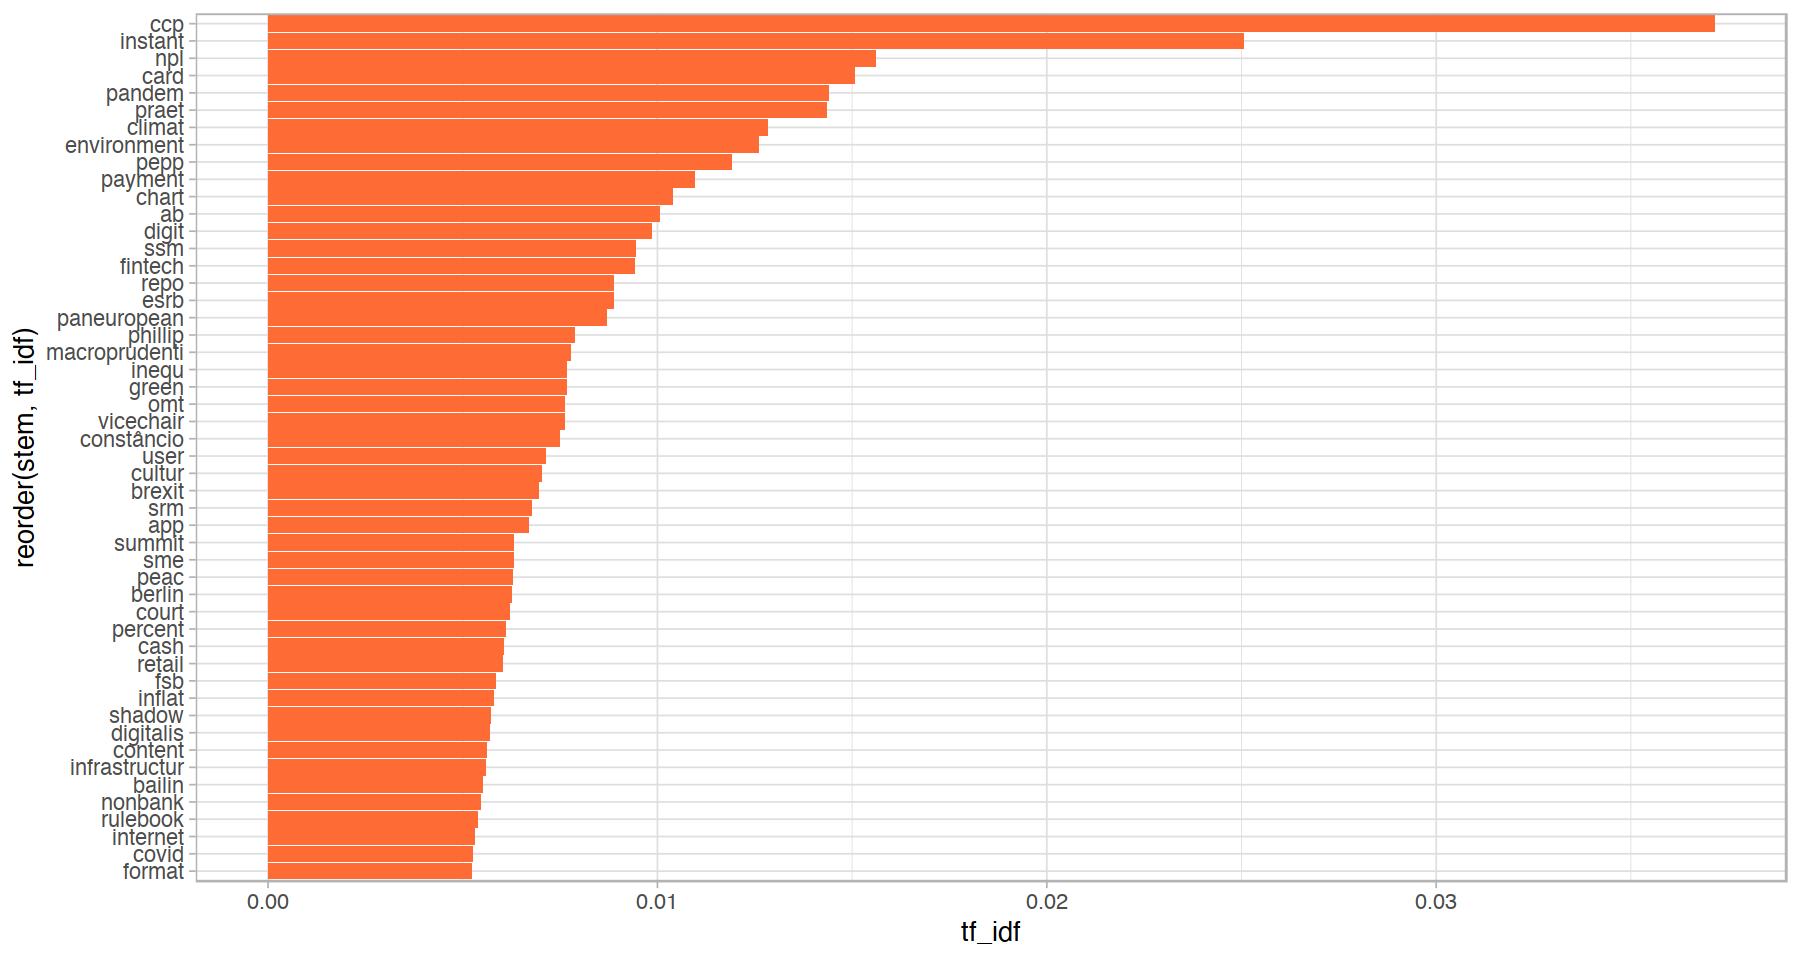

In [507]:
p1

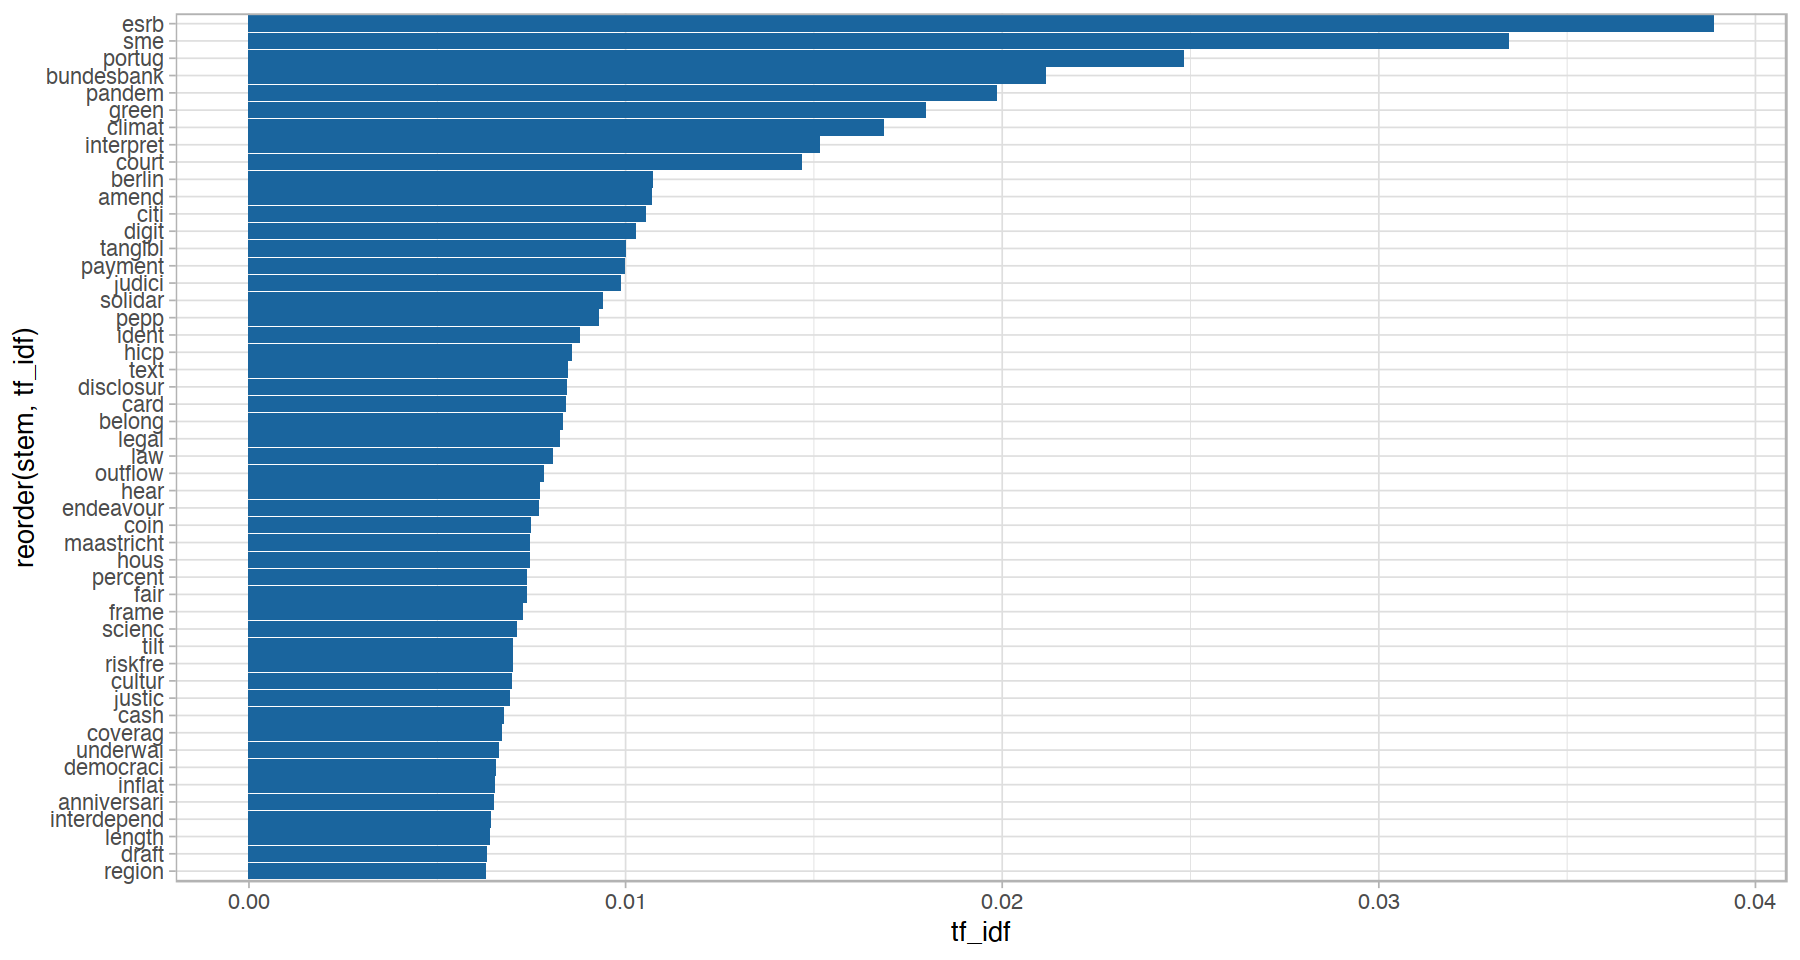

In [508]:
p2

## Regressions with text
- Our goal now is to try to predict speeches made by Christine Lagarde. This is a classification exercise
- One possibility is to predict: 

$$P[\text{Speaker}_d = \text{Christine Lagarde} | \mathbf{X_d}] $$

- $\mathbf{X_d}$ collates the tf-idf for all speeches. You could also add other variables (time, length, etc.)
- You know some classification algorithms: 
    - Logit
    - Linear Probability Model
- There are many more classification algorithms. 
    - One to learn, not touched upon in this class, are random forests
    

## Regressions with text

- The complexity that you will encounter with text: High dimensional data: $K>>N$
- We need to choose a method that works appropriately with text
- The most popular strategy for **penalized linear models**
    - LASS0
    - RIDGE
    - Others

## LASSO 

$$\hat{\mathbb{\beta}} = \text{argmin}_{\beta} \left\{ \frac{1}{2n} ||\mathbf{Y} - \mathbf{X\beta}||^2_2 + \lambda||\mathbb{\beta}||_1 \right\}$$
- There is a penalty term for increasing $\beta$. 
- Read more: because the penalty is L1 $\rightarrow$ feature selection (some paramters are set to 0)


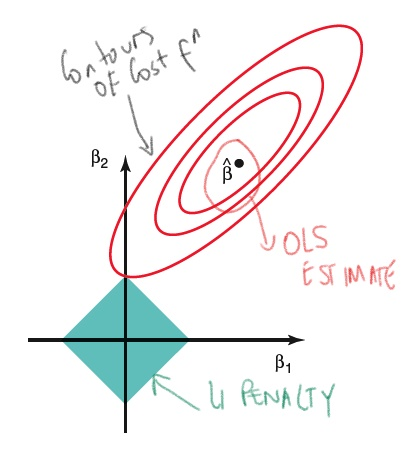

In [509]:
df_w <- read.csv("../data/output/speech_tfidf_20112022_wide.csv") #This db was further cleaned to drop recalcitrant stop words 
names(df_w)[1:10]

[1] "id"             "speakers"       "tf_idf_ab"      "tf_idf_abil"   
 [5] "tf_idf_abroad"  "tf_idf_abrupt"  "tf_idf_absenc"  "tf_idf_absolut"
 [9] "tf_idf_absorb"  "tf_idf_absorpt"

In [510]:
df_w$cl <- df_w$speakers == "Christine Lagarde"

## Create  training and test sample

- Important: these data are highly unbalanced 53 (5%) Lagarde Observations and 1090 others
- We are going to create a training sample that undersamples the majority category
- There are fancier techniques: 
    - For instance: you can oversample the minority group (duplicate entries)
    - This can create issues of overfitting the minority class
    - No recipe, just read and justify your choice
    - Beyond the scope of the class

In [511]:
# We are going to create an artificially balanced training dataset
# We do that here by undersampling the majority group
dim(df_w)
set.seed(7654321)
cltots <- sum(df_w$cl) #total of speeches by Lagarde
ncltots <- sum(!df_w$cl) #total of speeches by others
smp_size <- floor(cltots*0.8)
smp_size

indcl <- sample(x = cltots, size = smp_size)
indncl <- sample(x = ncltots, size= smp_size)

## Training data with 50/50 CL. Majority undersampled
traincl <- subset(df_w,cl)[indcl,]
trainncl <- subset(df_w,!cl)[indncl,]
train <- rbind(traincl, trainncl)

## Test data --> we will resample the data that was not selected to get a 5/95 split 
testcl <- subset(df_w,cl)[setdiff(1:cltots,  indcl),] 
testncl <- subset(df_w,!cl)[setdiff(1:ncltots,  indncl),] 
N <- floor(95/5*(cltots - smp_size))
tot <- dim(testncl)[1]
testncl2 <- testncl[sample(tot,size =  N ), ] #This undersamples the majority class to get the 5/95
test <- rbind(testcl, testncl2)

print(c("Dim train db: ", dim(train))) 
print(c("Dim test db: ", dim(test))) 


[1] 1143 2018

[1] 42

[1] "Dim train db: " "84"             "2018"          
[1] "Dim test db: " "220"           "2018"         


## Now the LASSO
 - We are going to use `gamlr` does a "gamma-lasso": 
     - Beyond the scope of this class to discuss this
     - Fast algorith
     - Read more on this algorithm: Taddy (2013, arxiv::1308.5623)
     
- Most common is `glmnet`. Very similar implementation
- They allow you to see what happens as you increase thepenalty parameter $\lambda$
 

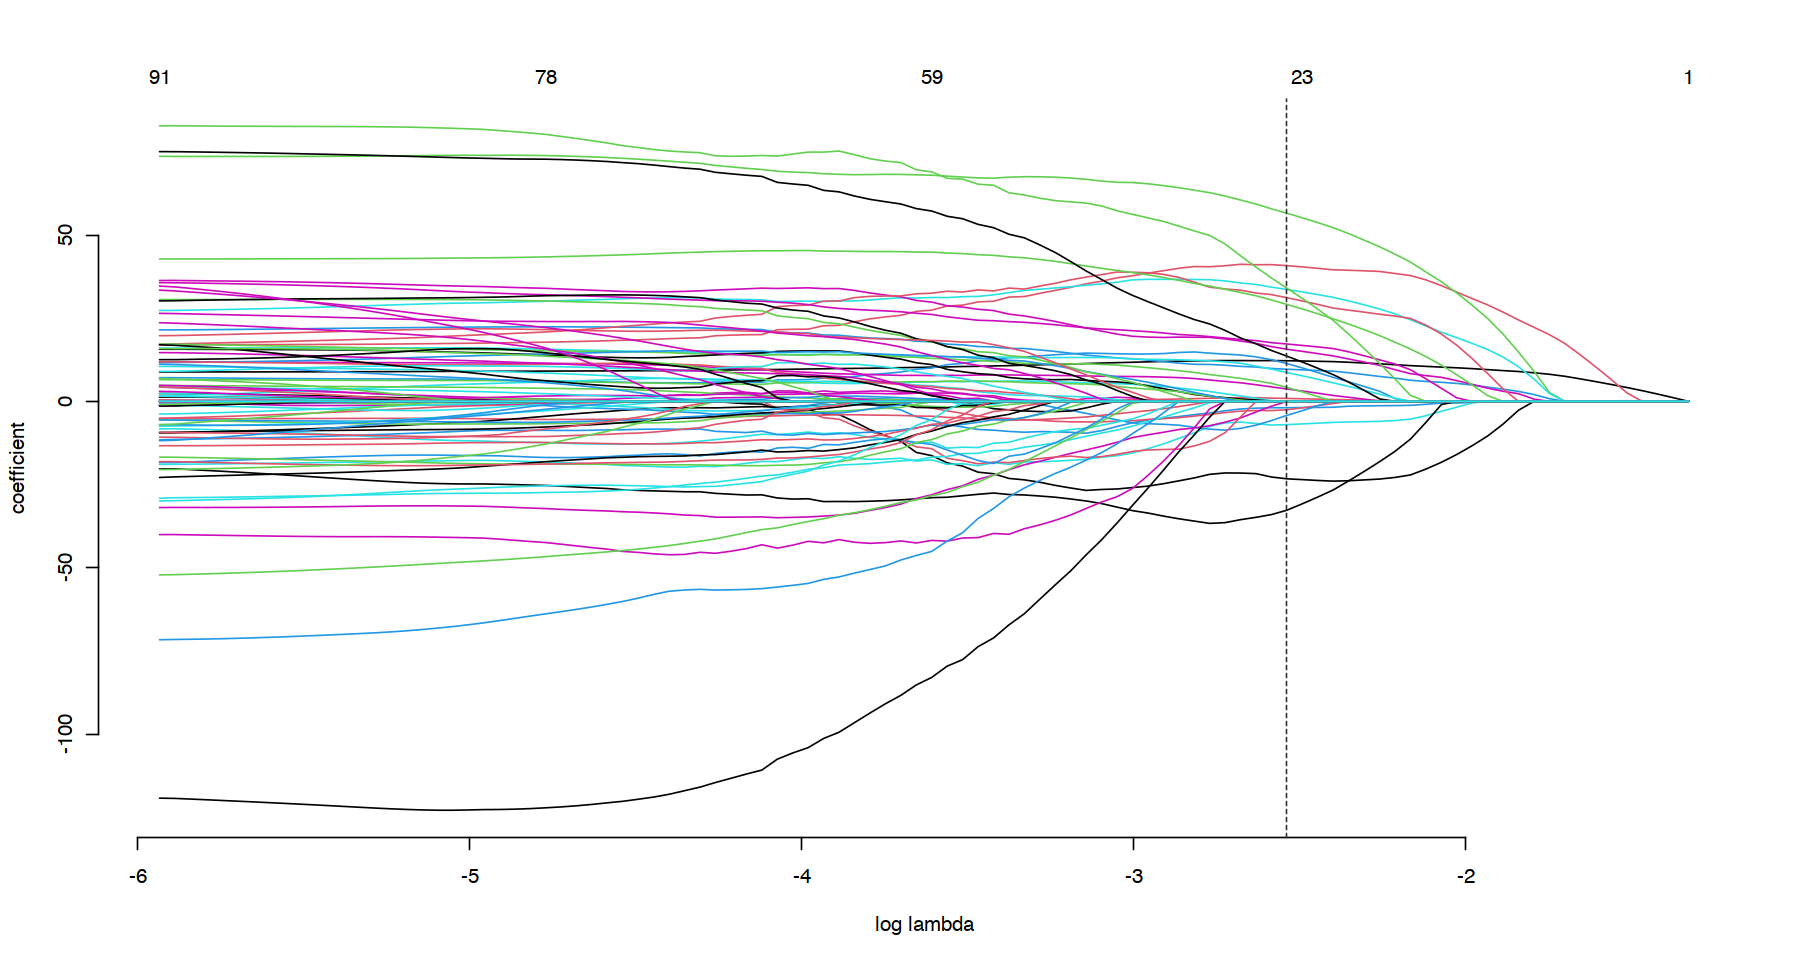

In [512]:
Y = train$cl
X = data.matrix(subset(train, select = -c(cl, speakers, id)))
la.eq <- gamlr(x = X, y =Y ) #Look: you can add the "binomial" option for a logistic LASSO
plot(la.eq) #The line in the plot gives the corrected-AIC (corrected is important for high-dimensionality)

## Selected Coefficients

In [513]:
AKoefs <- coef(la.eq)[-1,] #Let's look at all coefs, presented for min A-AIC criterion
AKoefs[sample(length(AKoefs),10)] #There are tons of 0s
Koefs <- AKoefs[AKoefs !=0] 



tf_idf_issuanc   tf_idf_spiral    tf_idf_bring    tf_idf_shown   tf_idf_stabil 
              0               0               0               0               0 
  tf_idf_access     tf_idf_quot tf_idf_guidelin  tf_idf_denomin     tf_idf_john 
              0               0               0               0               0

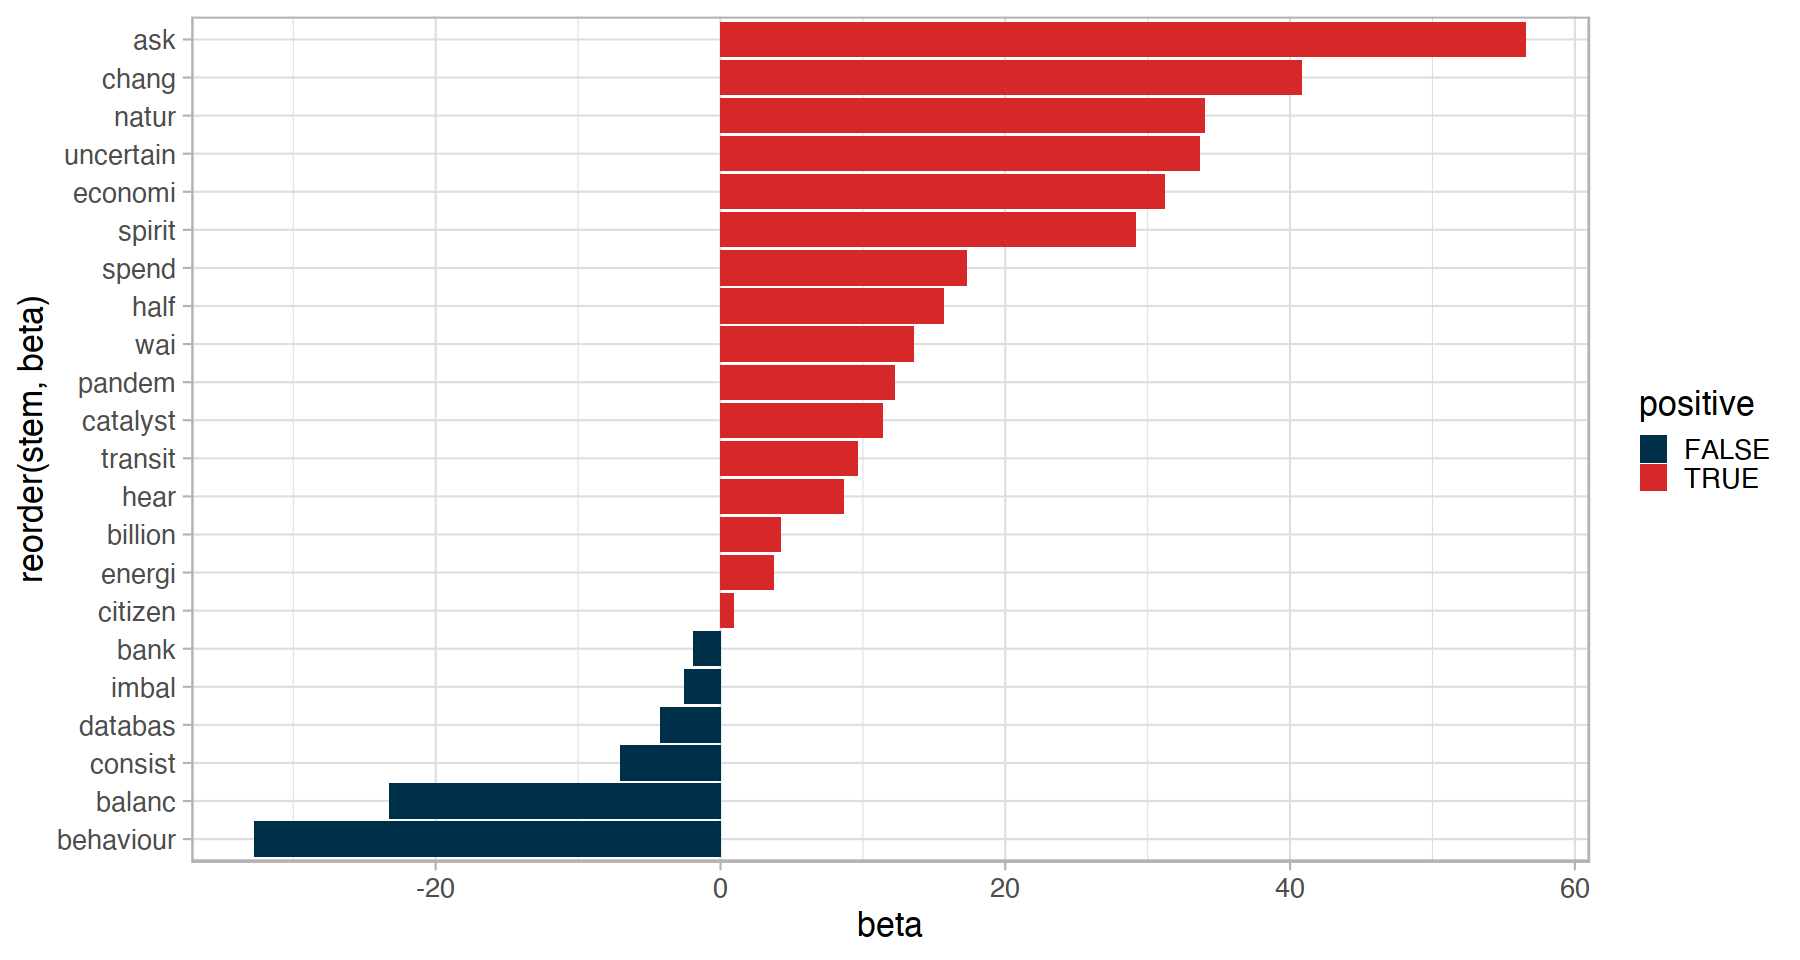

In [514]:
## Let's make a plot
K.df <- data.frame(stem = str_replace(names(Koefs),"tf_idf_", ""), beta = Koefs) ## The df for the plot
K.df$pos <- K.df$beta > 0
kols <- c( "#003049", "#d62828")
p3 <- ggplot(data = K.df , aes( x= beta, y = reorder(stem, beta))) + 
geom_bar(stat = "identity", aes(fill =  pos))  +
scale_fill_manual(values = kols,  name = "positive") +
 theme_light(base_size = 20)
p3

## How well do we do on the test data?

In [515]:
#Make prediction
X2 <- data.matrix(subset(test, select =  -c(cl, speakers, id)))
pred <- predict(la.eq, newdata = X2) # Predict the outcome in the test data. (this does a dancy variation of OLS on selected features)

In [516]:
pred.df <- data.frame(cl = test$cl, probs = pred[,1]) ## a df with predictions
pred.df.sum <- pred.df %>% group_by(cl) %>% summarize_all(c("mean", "sd"))
pred.df.sum

cl,mean,sd
<lgl>,<dbl>,<dbl>
FALSE,0.3033705,0.1255997
TRUE,0.8413179,0.0986856


## What if we choose a cutoff for the label?

Let's decide that for any estimated probability above a given $\bar{p}$, we predict the speech as being from CL 

In [517]:
pred.df$clpred <- (pred.df$probs > 0.5) # Higher than 50% chance of being CL
T<- table(pred.df$cl, pred.df$clpred) #columns: second var; rows: firstvar
T

       
        FALSE TRUE
  FALSE   193   16
  TRUE      0   11

In [518]:
print("True positive Rate")
T[2,2]/sum(T[2,])
print("True Negative Rate")
T[1,1]/sum(T[1,])
print("Type-1 error (false positives)") 
T[1,2]/sum(T[,2])
print("Type-2 error (false negatives)")
T[2,1]/sum(T[,1])


[1] "True positive Rate"


[1] 1

[1] "True Negative Rate"


[1] 0.923445

[1] "Type-1 error (false positives)"


[1] 0.5925926

[1] "Type-2 error (false negatives)"


[1] 0

## Conclusion of the classification exercise

- Our classification method is not great. 
- But you've learnt new methods! 
- Also you've learnt how to test a method
- How could this be improved? 
    - Sample size: oversample minority or other fancier ways of creating training data
    - Further cleaning: with text, you are never done cleaning...


In [519]:
rm(list = setdiff(ls(), "df.words.n"))

## Dictionary methods

- Another common form of classification of texts involves dictionaries
- Recall the question about asking whether speeches talked about climate?
    - We said that our raw data was unlabelled for such a question
    - If I have a dictionary of climate terms, such as: 
    $$ \text{Climate} = [\text{green, environment, renewable, ..., sustainable}]$$
    - Then I can actually think about the problem of estimating: 
    $$P[\text{Climate Topic} | \mathbf{X}]$$

## Sentiment Analysis

- **One common application of dictionaries:** sentiment analysis
- A dictionary of terms considered positive, negative, uncertain, agressive, etc.
- Dictionaries are strongly dependent on the context: 
- **"Cancer"** is probably negative in a corpus of personal diaries, probably neutral in a corpus of horoscopes, probably positive in a corpus of pharma companies research reports
- **"Brutal"** is  bad in a corpus of newspaper articles about the war in Ukraine, could be positive in a corpus of sports articles.

## Sentiment Analysis: a tryout

- The goal is to experiment with sentiment analysis using the same db of ECB speeches
- Normally, this would be done using full words (see [documentation for Koughran and MacDonald, 2011](https://sraf.nd.edu/loughranmcdonald-master-dictionary/))
- For the context of this class, we will use stems
    - Faster and we already created a DB of stems
- Rely on the dictionary for words in financial texts: Loughran and McDonald (2011)
    - This may not be up to date for this application
    - It doesn't matter for the purpose of this application

## Sentiment Analysis: a tryout

In [520]:
df.sent <- read.csv("../data/Loughran-McDonald_simplified.csv") #Import the data
head(df.sent, n= 5)

,X,stem,positive,negative,uncertainty,litigious
,<int>,<chr>,<int>,<int>,<int>,<int>
1,1,abandon,0,1,0,0
2,2,abdic,0,1,0,0
3,3,aberr,0,1,0,0
4,4,abet,0,1,0,0
5,5,abey,0,0,1,0


## Sentiment Analysis: a tryout

With this database, we can create an indicator of each sentiment per document
For a document $d$, we can define how positive it is as: 
$$\text{Positive}_d = \sum_{t} tfidf(t,d)*\mathbb{1}\{t \in \text{Positive}\}$$
Where $\text{Positive}$ is the list of terms considered "positive". 


In [521]:
df <- read.csv("../data/output/speech_tfidf_20112022.csv") #Let's load again the db of docs with tf_idf
names(df)

[1] "X"        "id"       "stem"     "n"        "tf"       "idf"     
 [7] "tf_idf"   "date"     "speakers" "title"

#### What words are in each sentiment?

In [522]:
#list of positive, negative, uncertain, and litigious words
pos <- df.sent$stem[which(df.sent$positive>0)]
neg <- df.sent$stem[which(df.sent$negative>0)]
unc <- df.sent$stem[which(df.sent$uncertainty>0)]
lit <- df.sent$stem[which(df.sent$litigious>0)]

In [523]:
pos[sample( length(pos), 10)]

[1] "winner"     "ingenu"     "inspir"     "versatil"   "succe"     
 [6] "influenti"  "outperform" "rebound"    "incredibli" "pleasur"

In [524]:
neg[sample( length(neg), 10)]

[1] "impass"     "unproduct"  "unsustain"  "unavail"    "erod"      
 [6] "divulg"     "depress"    "undermin"   "hurt"       "misclassif"

In [525]:
unc[sample( length(unc), 10)]

[1] "reinterpret" "fluctuat"    "somewhat"    "unusu"       "instabl"    
 [6] "differ"      "approxim"    "unspecif"    "unobserv"    "volatil"

In [526]:
lit[sample( length(lit), 10)]

[1] "hereinbelow" "nolo"        "cession"     "herefrom"    "law"        
 [6] "whereund"    "anteced"     "dispossess"  "supersed"    "patente"

## Activity: Create a variable with the average of each sentiment for each document

In [527]:
# For this purpose, we can already drop all the words that are not in any category
dim(df)
df.small <- subset(df, stem %in% df.sent$stem)
dim(df.small)

[1] 492554     10

[1] 73167    10

In [528]:
#Full database with tfidf and sentiments
df.full <- left_join(df.small, df.sent, by = "stem")
df.full$X.x <- NULL
df.full$X.y <- NULL
df.full$title <- NULL
head(df.full, n = 3)


,id,stem,n,tf,idf,tf_idf,date,speakers,positive,negative,uncertainty,litigious
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,id_0001,abrupt,1,0.0003750938,2.8047163,0.0010520316,2022-02-28,Fabio Panetta,0,1,0,0
2,id_0001,achiev,2,0.0007501875,0.4136284,0.0003102989,2022-02-28,Fabio Panetta,1,0,0,0
3,id_0001,advanc,3,0.0011252813,0.9409833,0.0010588710,2022-02-28,Fabio Panetta,1,0,0,0


In [529]:
# Let's create columns with tfidf* sentiment
X_wsent <- df.full$tf_idf * df.full[,c("positive", "negative", "uncertainty", "litigious")]
X_wsent <- cbind( df.full[,c("id", "date", "speakers")], X_wsent )
head(X_wsent, n = 2)

,id,date,speakers,positive,negative,uncertainty,litigious
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,id_0001,2022-02-28,Fabio Panetta,0.0000000000,0.001052032,0,0
2,id_0001,2022-02-28,Fabio Panetta,0.0003102989,0.000000000,0,0


In [530]:
# Summarize categories per document
df.perdoc <- X_wsent %>% group_by(id, date, speakers) %>% summarize_all('sum')
df.perdoc$date2 <- ymd(df.perdoc$date)
head(df.perdoc, n =3)

id,date,speakers,positive,negative,uncertainty,litigious,date2
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
id_0001,2022-02-28,Fabio Panetta,0.02295036,0.07036806,0.022708266,0.004150008,2022-02-28
id_0002,2022-02-24,Isabel Schnabel,0.01778884,0.03948828,0.018949500,0.006978195,2022-02-24
id_0003,2022-02-23,Frank Elderson,0.01610757,0.01142907,0.002079856,0.058085941,2022-02-23


## How has sentiment evolved? (raw!)

Let's plot how the sentiment of each speech has evolved over time in our sample (2012-2022)

`geom_smooth()` using formula 'y ~ x'



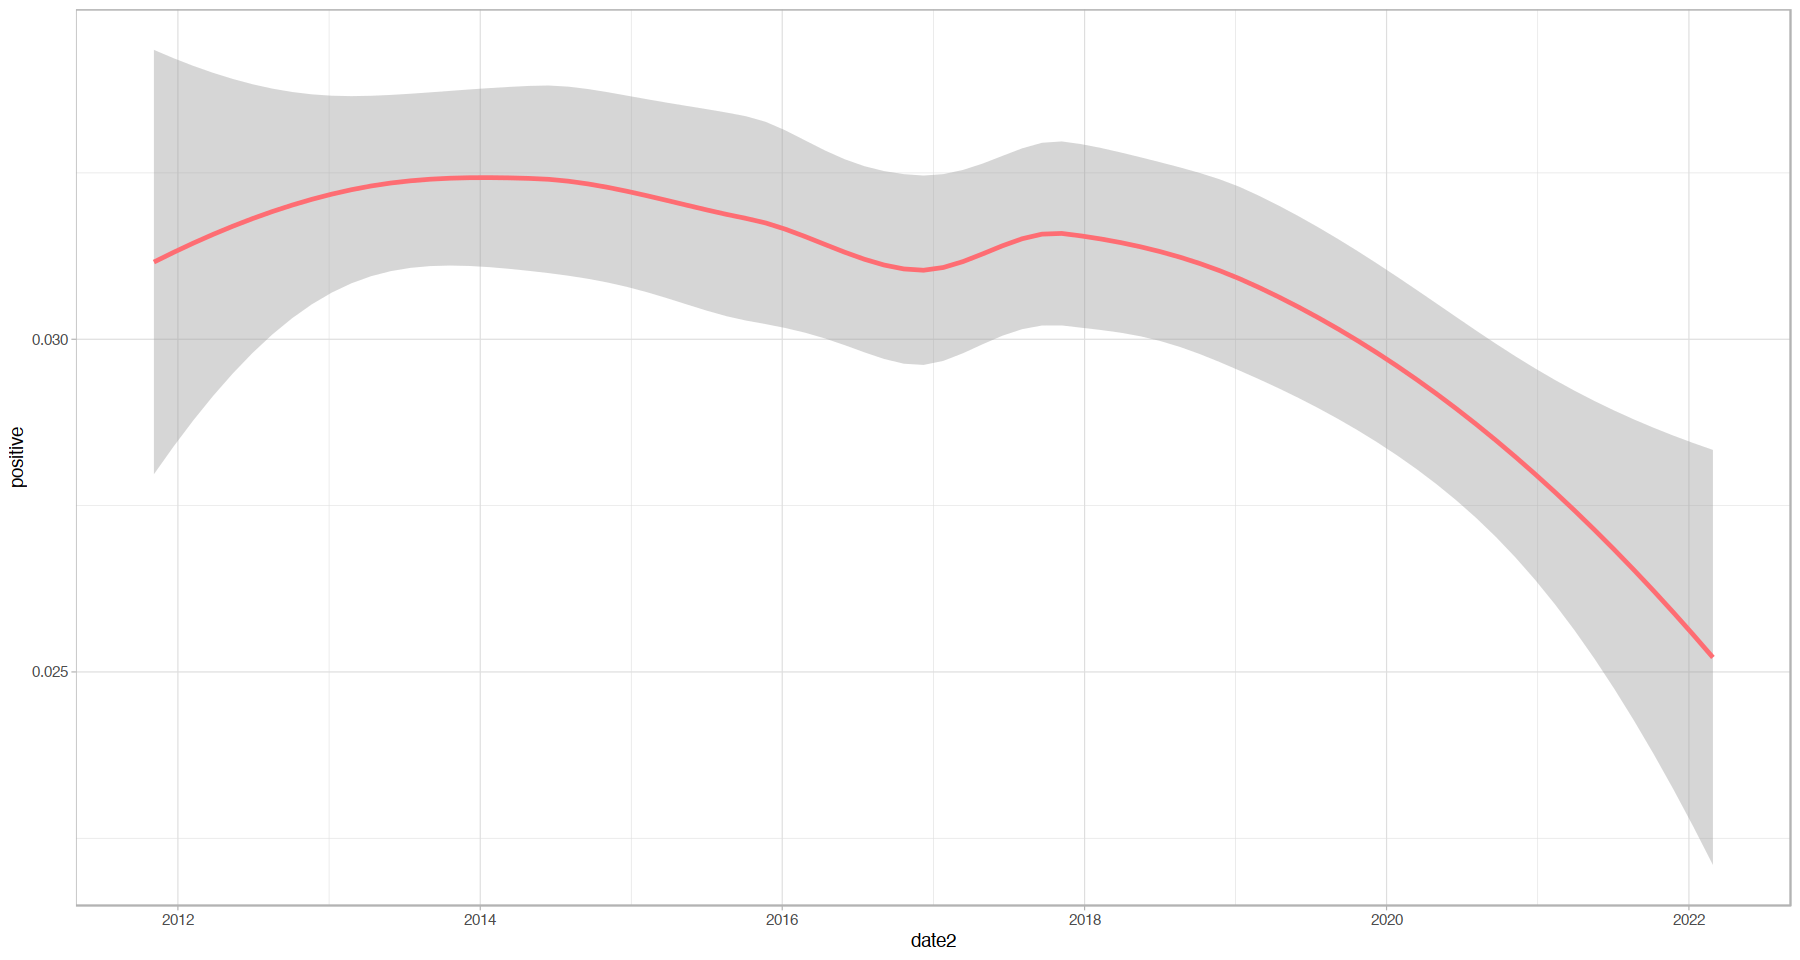

In [531]:
ggplot(data = df.perdoc, aes(x = date2, y = positive)) +
    geom_smooth(method = "loess",col = "#FE6D73" ) + theme_light()

`geom_smooth()` using formula 'y ~ x'



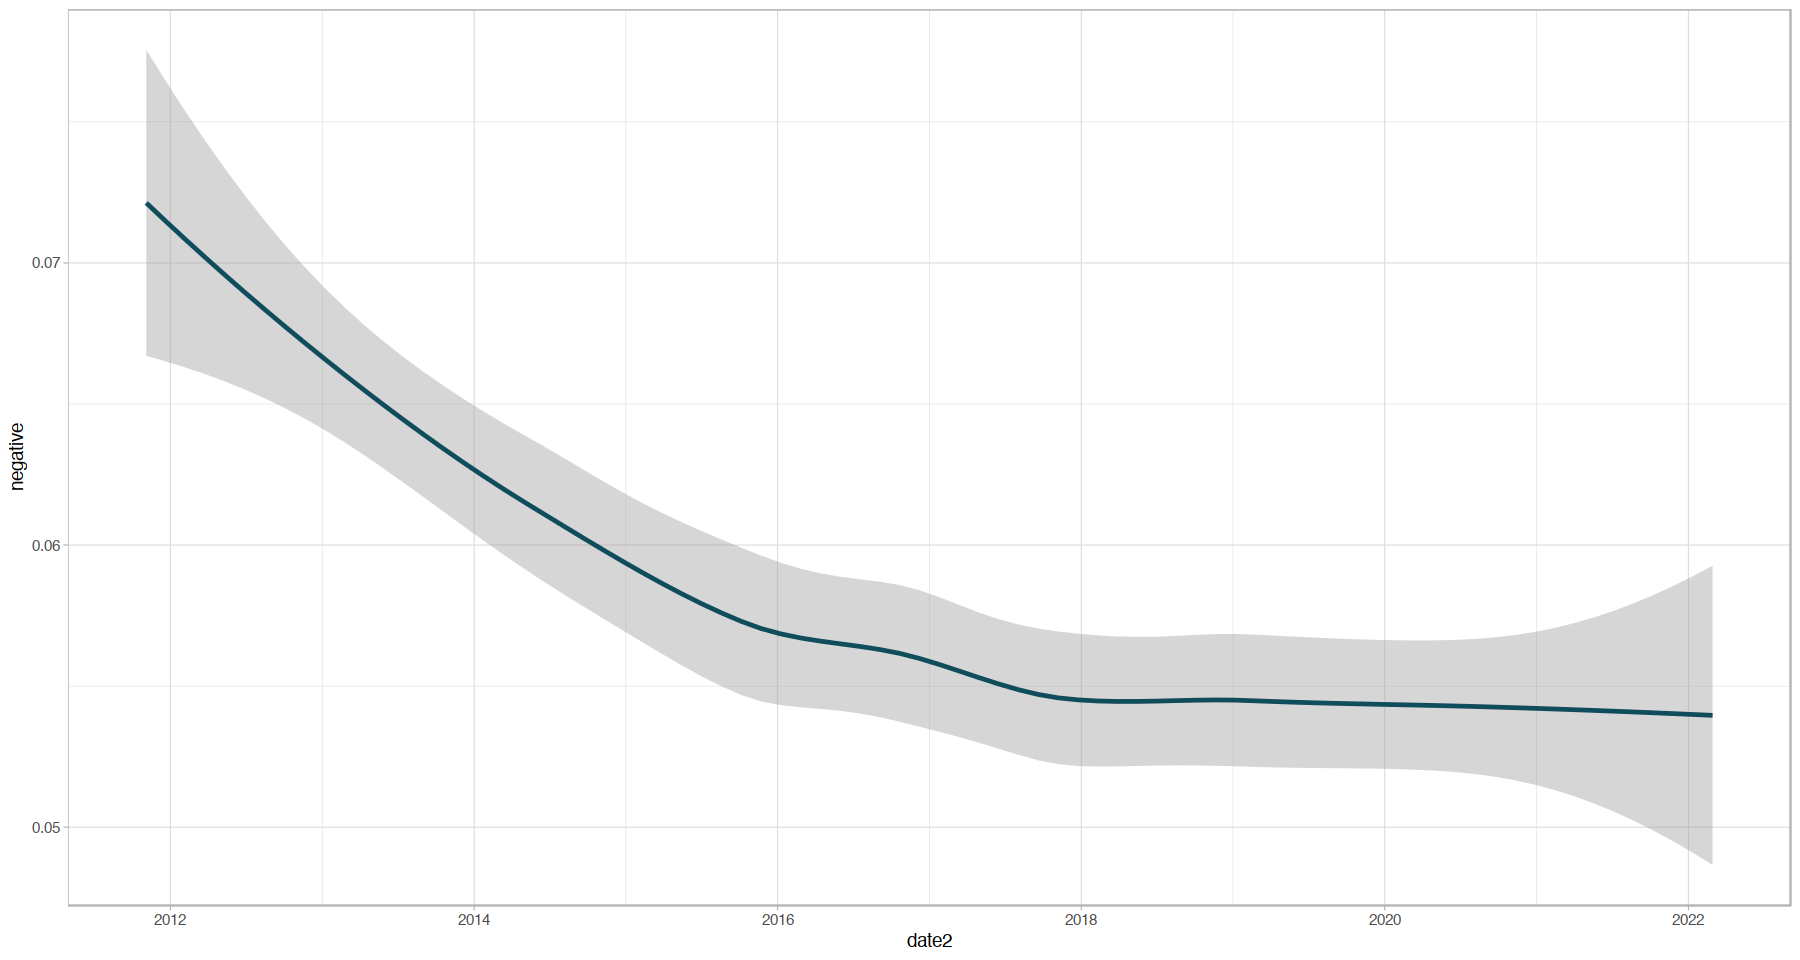

In [532]:
ggplot(data = df.perdoc, aes(x = date2, y = negative)) +
    geom_smooth(method = "loess",col = "#0F4C5C" ) +theme_light()

`geom_smooth()` using formula 'y ~ x'



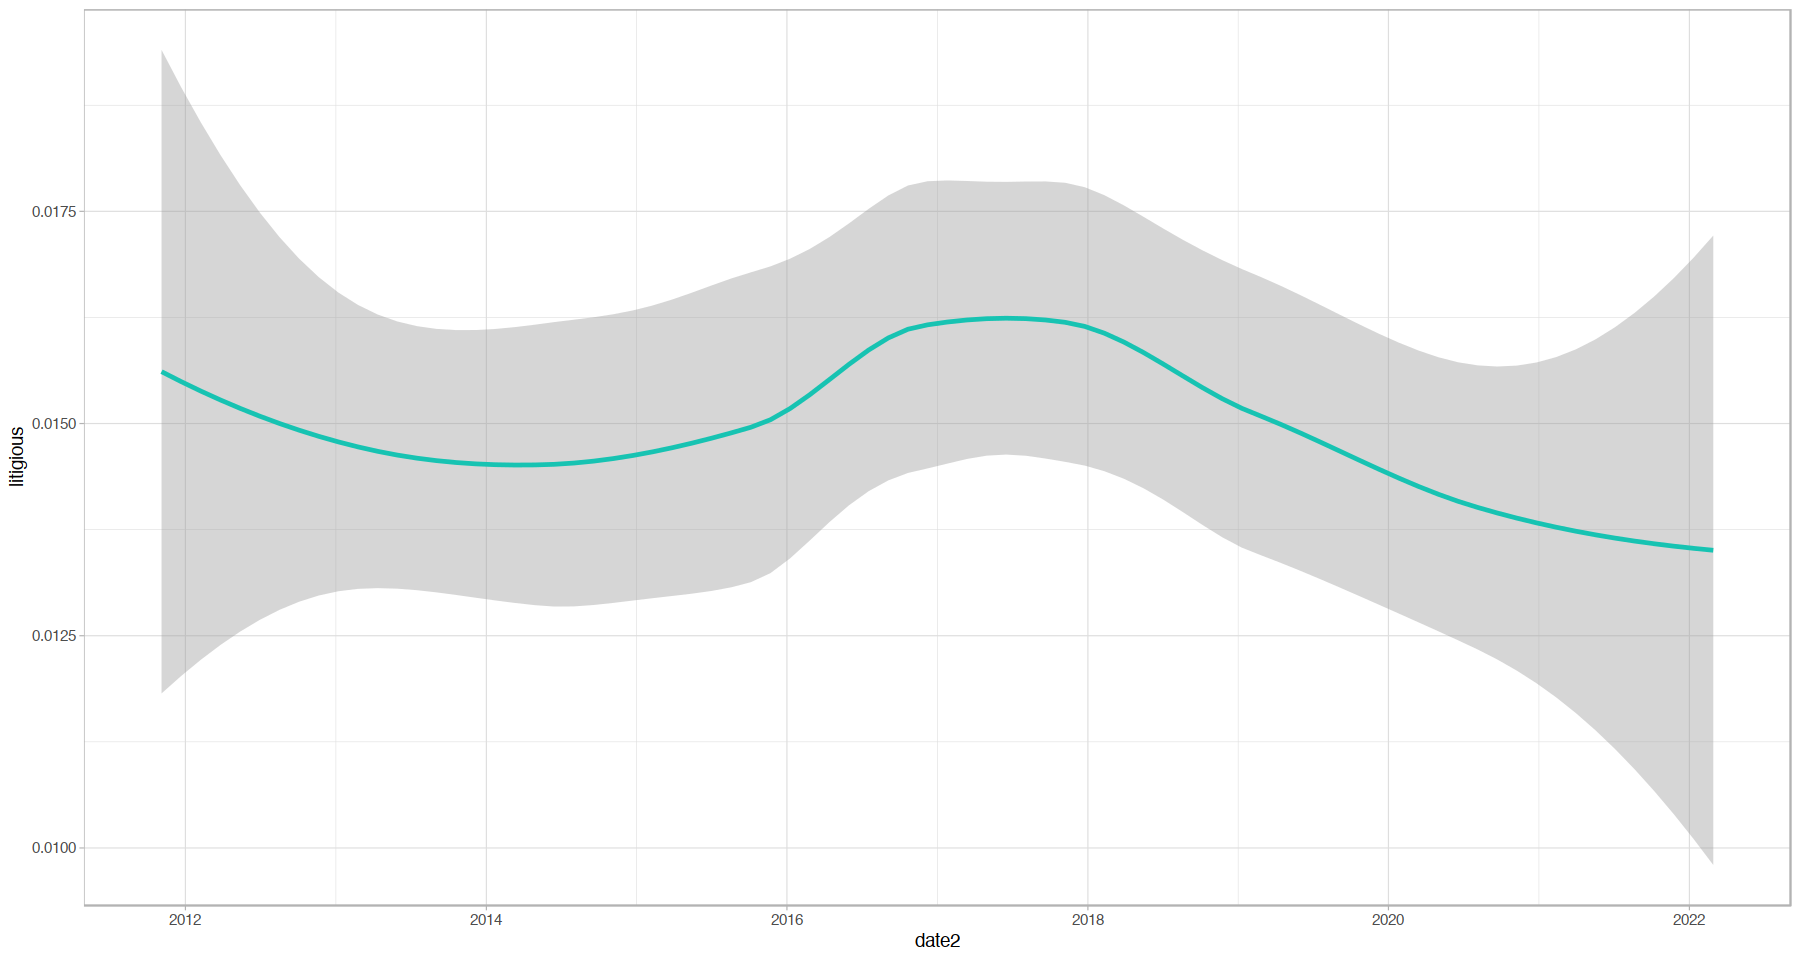

In [533]:
ggplot(data = df.perdoc, aes(x = date2, y = litigious)) +
    geom_smooth(method = "loess",col = "#17C3B2" ) +theme_light()

`geom_smooth()` using formula 'y ~ x'



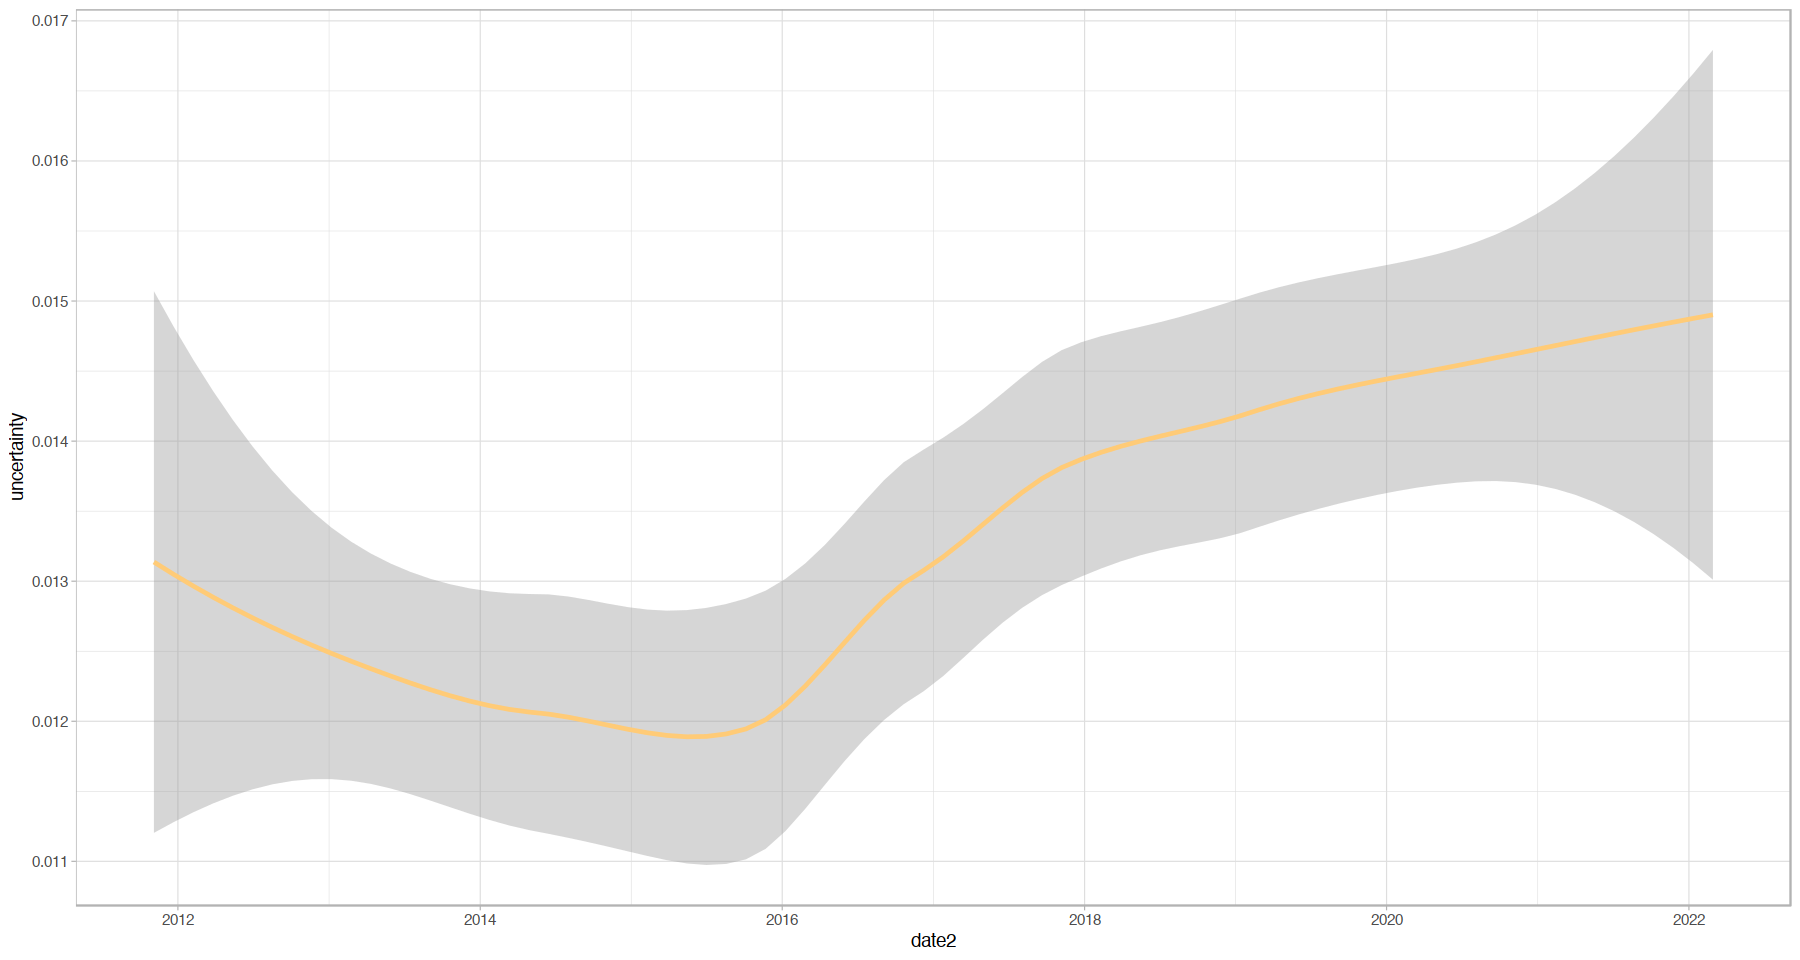

In [534]:
ggplot(data = df.perdoc, aes(x = date2, y = uncertainty)) +
    geom_smooth(method = "loess",col = "#FFCB77" ) +theme_light()

## Average sentiment per speaker

In [535]:
df.perspeak <- df.perdoc %>% group_by(speakers) %>% 
summarize_at(c("positive", "negative", "litigious", "uncertainty"), "mean") 

In [536]:
df.perspeak

speakers,positive,negative,litigious,uncertainty
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Benoît Cœuré,0.02863219,0.06000155,0.016197282,0.013446379
Christine Lagarde,0.03387471,0.05058812,0.012631633,0.013982408
Fabio Panetta,0.02761080,0.04947038,0.013021822,0.012019549
Frank Elderson,0.02620359,0.04114893,0.029595218,0.011974297
Isabel Schnabel,0.01971175,0.06278087,0.007680581,0.019116050
Jörg Asmussen,0.03421389,0.06713906,0.012642400,0.008986364
José Manuel González-Páramo,0.03106475,0.08469650,0.017361989,0.012127220
Jürgen Stark,0.03054711,0.06748698,0.017778808,0.010609303
Lorenzo Bini Smaghi,0.03649343,0.08420588,0.008869501,0.025299459


In [537]:
df.perspeak.l <-  df.perspeak %>% gather(sentiment, value, -c(speakers))
df.perspeak.l$speakers <- str_replace( df.perspeak.l$speakers, "Ben.+C.+r.{1}$" ,  "Benoit Coeure")
df.perspeak.l$speakers <- str_replace( df.perspeak.l$speakers, "^J.+rg.+Asmussen$$" ,  "Jorg Asmussen")
head(df.perspeak.l)


speakers,sentiment,value
<chr>,<chr>,<dbl>
Benoit Coeure,positive,0.02863219
Christine Lagarde,positive,0.03387471
Fabio Panetta,positive,0.02761080
Frank Elderson,positive,0.02620359
Isabel Schnabel,positive,0.01971175
Jorg Asmussen,positive,0.03421389


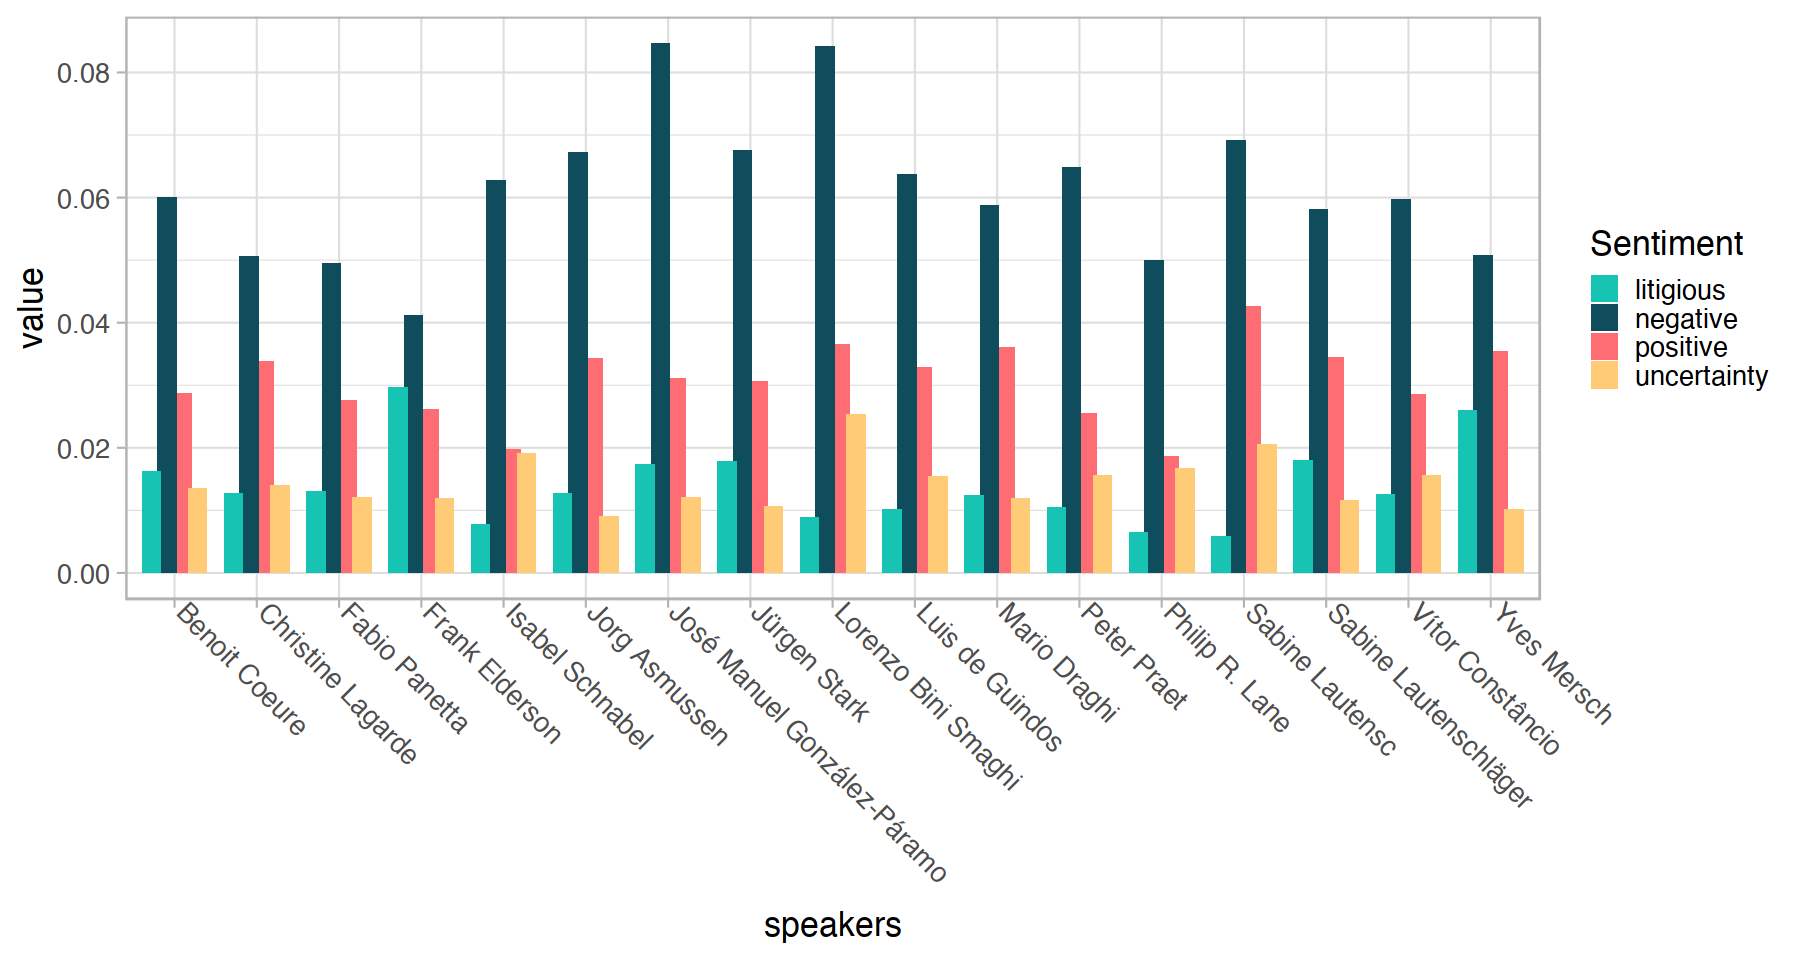

In [538]:
options(repr.plot.width=15, repr.plot.height=8)
kols <- c("#17C3B2", "#0F4C5C", "#FE6D73", "#FFCB77")
ggplot(data = df.perspeak.l , aes( y= value, x = speakers)) + 
geom_bar( aes(fill = sentiment), position = position_dodge(0.75), stat = "identity")  +
scale_fill_manual(values  = kols, name = "Sentiment") +
theme_light(base_size = 20) + theme(axis.text.x = element_text(angle = -45, vjust = 0, hjust=0))

## Topic Modelling

- Can we group documents inside a corpus according to their content? 
- Are some documents more similar to one another? 
- **Unsupervised**: We want to group texts without any ideo of pre-existing labels
- Dimensionality reduction: 
    - You could start with PCA
    - LSA (Latent Semantic Analysis), similarly, uses singular value decomposition  to "reduce" the document$\times$term matrix
- A more elaborate, but higher performing method: Latent Dirichlet Alllocation (LDA)

### Latent Dirichlet allocation
- Hierarchical Bayesian model 
- A generative probabilistic model of a corpus
- Documents are random mixtures over latent topics, and topics a represented by a distribution over words. 
- The setup is clearly described in the original paper: Blei, Ng, Jordan (2003) "Latent Dirichlet Allocation", *Journal of Machine Learning Research*, 993-1022


### Latent Dirichlet allocation
- A *word* is an item from a vocabulary indexed by $\{1,...,V\}$. Words are vectors with one single component equal to one (one-hot)
- A *document* is a sequence of $N$ words denoted $\mathbf{w}=(w_1,....,w_N)$, where $w_n$ is the $n$-th word.
- A corpus is a collection of $M$ docs denoted $\mathcal{D}=\{\mathbf{w}_1,...,\mathbf{w}_M\}$

### Latent Dirichlet allocation
Docs are represented as random mixtures over latent topics, and topics are characterised by distrib over words
**Generative Process**
For each doc $\mathbf{w}$ in corpus $\mathcal{D}$:
 1. Choose $N \sim \text{Poisson}(\xi)$ 
 2. Choose $\theta \sim \text{Dir}(\alpha)$ (prior over topic distribution per doc)
 
For each of the $N$ words in doc: 
 1. Choose a topic $z_n \sim \text{Multinomial}(\theta)$
 2. Choose a word $w_n$ from $p(w_n|z_n, \beta)$ 


- With these assumptions, we can state:
    - The joint distribution of topic mixture $\theta$, set of topics $\mathbf{z}$, and a set of words $\mathbf{w}$:
$$P(\theta, \mathbf{z},\mathbf{w}|\alpha \beta )$$
    - The marginal distribution of a document: $P(\mathbf{w}|\alpha, \beta)$
    - The marginal distribution of a corpus $p(\mathcal{D}|\alpha, \beta)$
- **Inferential problem:** Use Bayes' theorem to get the *posterior*, the probability of the hidden variables. The hidden variables are the of topics per word $z$ and the distribution of topics per document $\theta$
$$p(\theta, \mathbf{z} | \mathbf{w}, \alpha, \beta)$$
- Algorith to compute this: complicated. Beyond the scope of the class
- In R, it is implemented through the library `topicmodels`


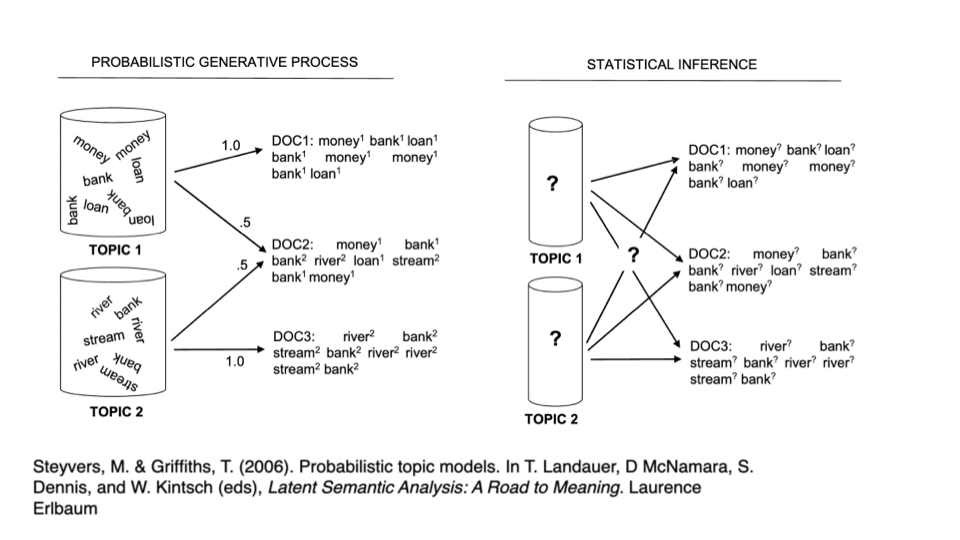

In [2]:
##Start with our document-term matrix, which was df.words.n
head(df.words.n)
dtm <- df.words.n %>% cast_dtm(document = id, term = stem, value = n)
dtm

ERROR: Error in head(df.words.n): object 'df.words.n' not found


In [558]:
df_lda <- LDA(dtm, k =2 )

In [559]:
df_lda_tidy <- tidy(df_lda, matrix = "beta")
head(df_lda_tidy)

topic,term,beta
<int>,<chr>,<dbl>
1,abat,1.882208e-05
2,abat,6.047822e-06
1,abovetarget,9.775614e-06
2,abovetarget,9.082412e-31
1,abrupt,7.673573e-05
2,abrupt,4.420337e-05


In [560]:
df_top_terms <- df_lda_tidy %>%
  group_by(topic) %>%
  slice_max(beta, n = 20) %>% 
  ungroup() %>%
  arrange(topic, -beta)

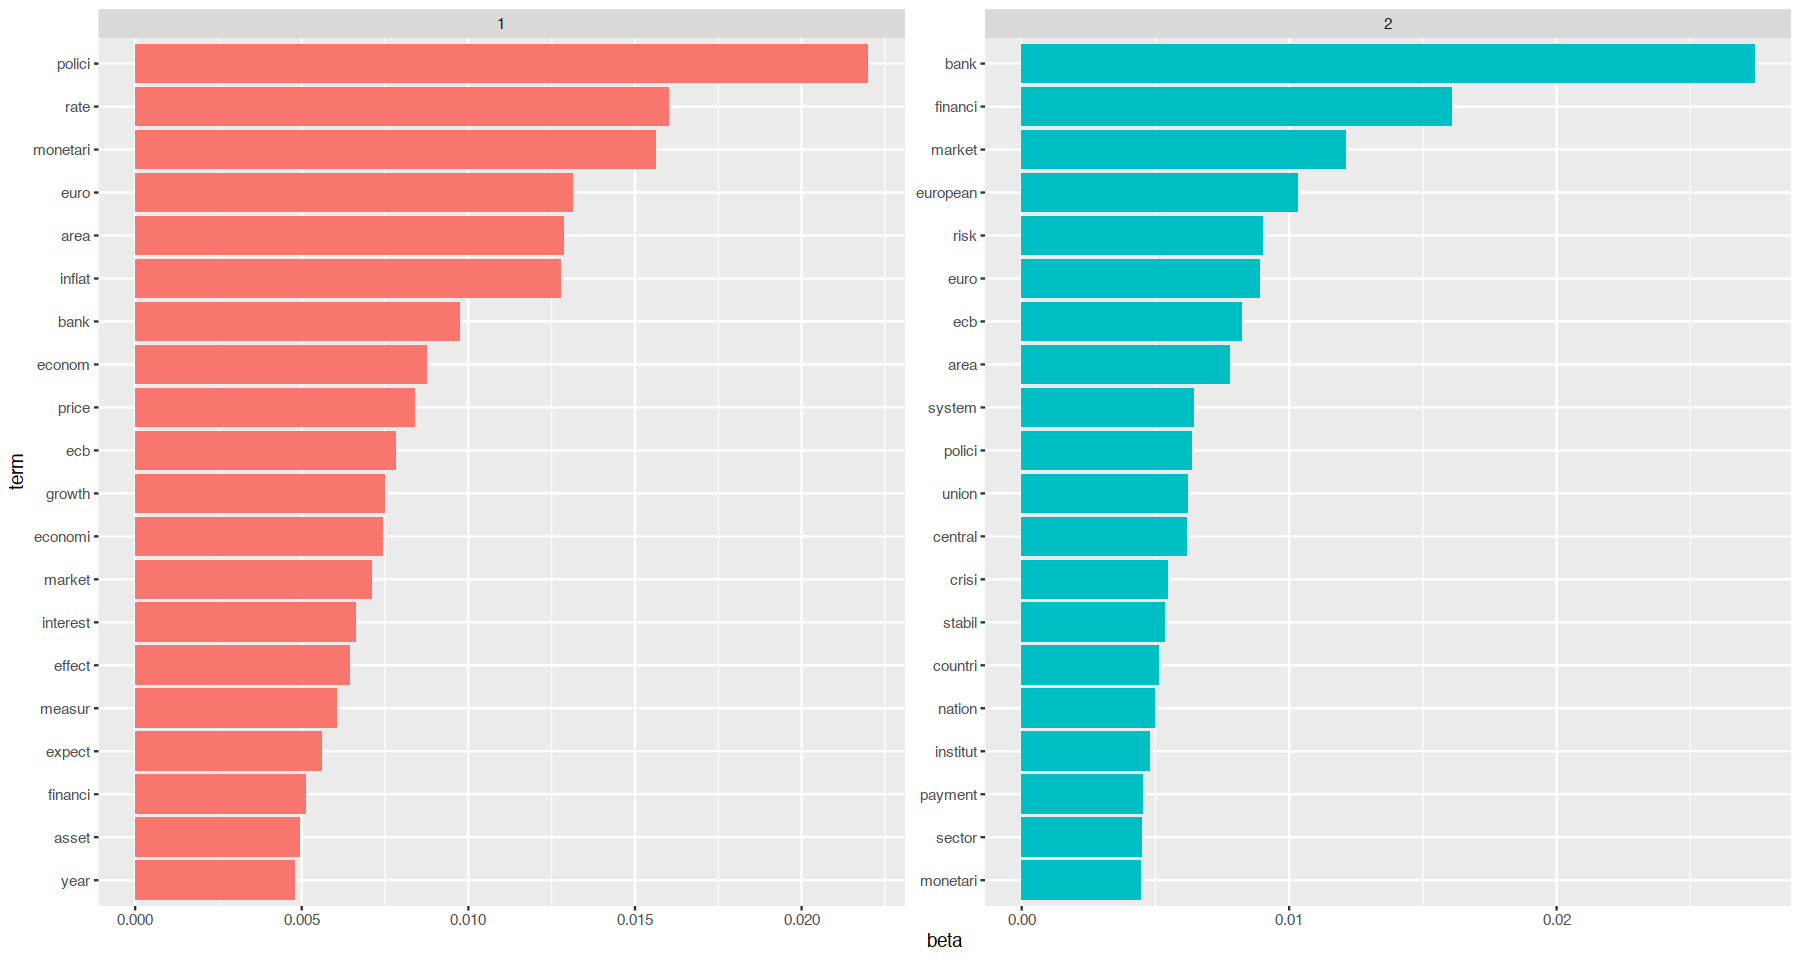

In [561]:
df_top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(beta, term, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  scale_y_reordered()

In [567]:
beta_wide <- df_lda_tidy %>%
  mutate(topic = paste0("topic", topic)) %>%
  pivot_wider(names_from = topic, values_from = beta) %>% 
  filter(topic1 > .001 | topic2 > .001) %>%
  mutate(log_ratio = log2(topic2 / topic1))

head(beta_wide)

term,topic1,topic2,log_ratio
<chr>,<dbl>,<dbl>,<dbl>
accommod,0.0013633696,0.0000250564,-5.7658538
achiev,0.0008161568,0.0016818672,1.0431456
action,0.0008905576,0.0015424098,0.7924054
activ,0.0014569577,0.0017101440,0.2311588
addit,0.0011976260,0.0010102877,-0.2454112
address,0.0006542738,0.0021752551,1.7332183


In [568]:
beta_wide_ext <-  rbind(beta_wide %>%  slice_max(log_ratio, n = 20) , 
                       beta_wide %>%  slice_min(log_ratio, n = 20) )


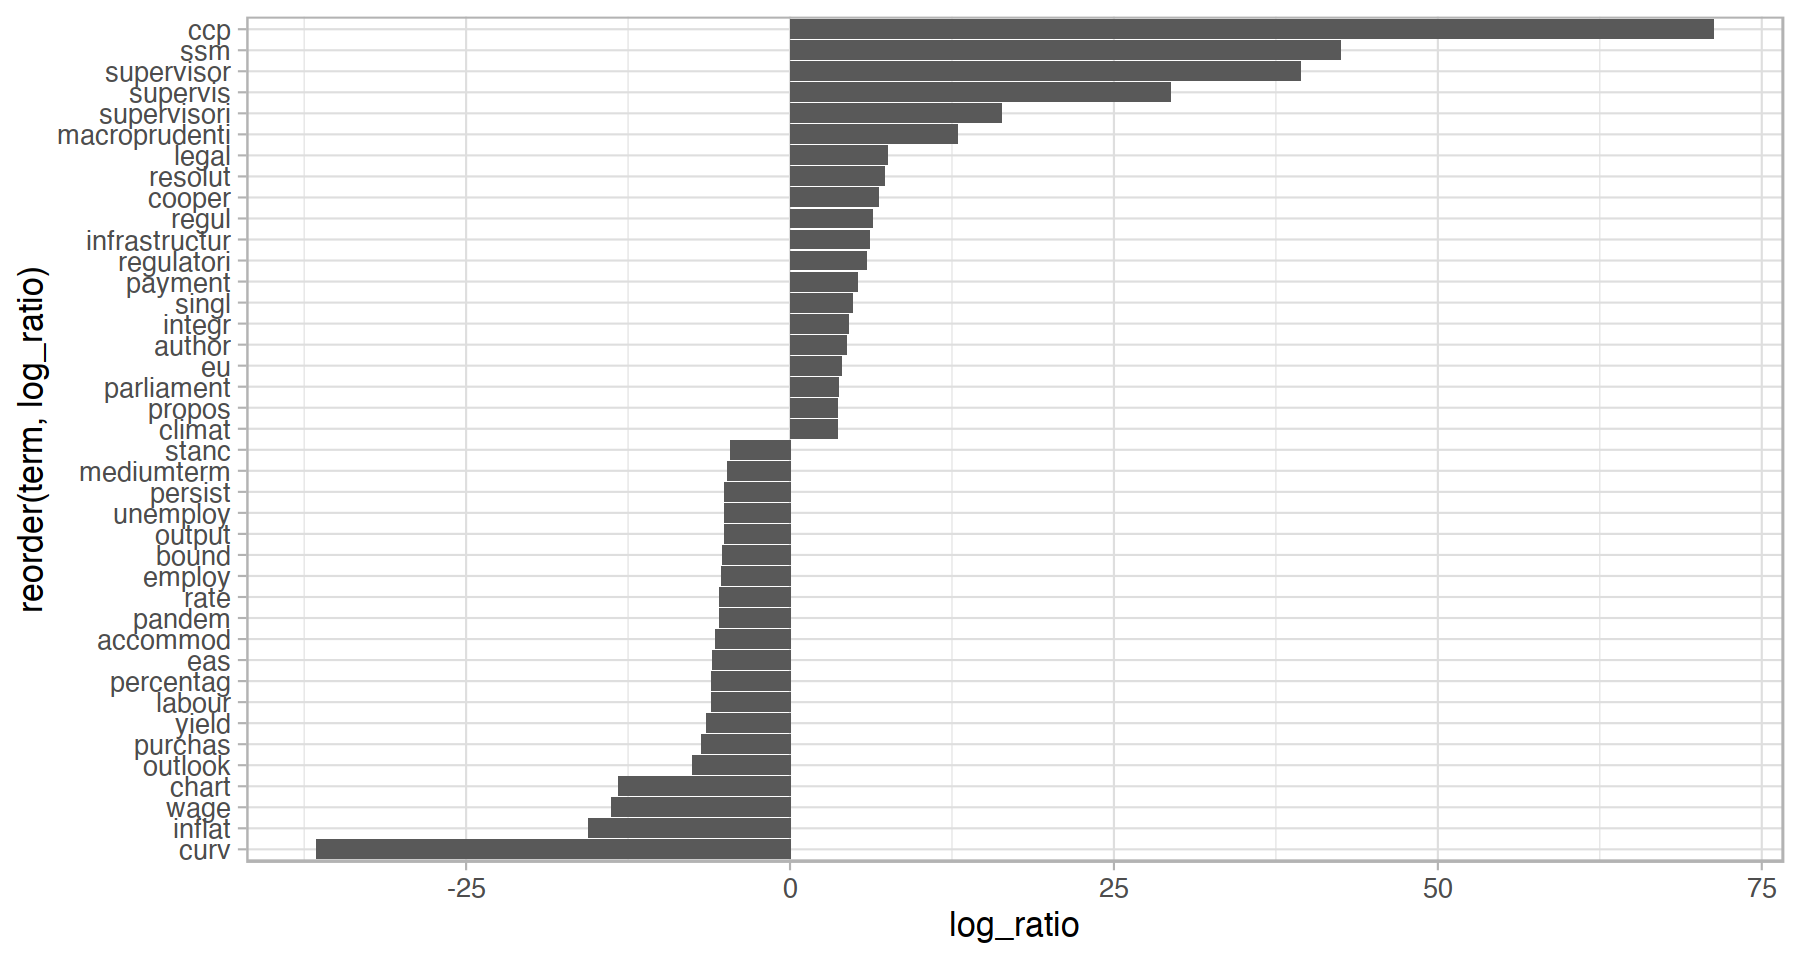

In [571]:
ggplot(data = beta_wide_ext , aes( x= log_ratio, y = reorder(term, log_ratio))) + 
geom_bar(stat = "identity" ) +
theme_light(base_size = 20)